# Dynamic Initializer Analysis

**Date:** 2025-12-29  
**Tags:** #continuos-preintegration #optimization

This notebook reimplements the `DynamicInitializer::initialize` function from OpenVINS in Python for analysis and understanding.

## Overview
The dynamic initialization algorithm recovers:
- IMU orientation, position, velocity, and biases
- Feature 3D positions
- Using visual measurements and IMU preintegration over a sliding window

## Algorithm Steps
1. **Data Validation**: Check we have enough features and IMU measurements
2. **Linear System**: Solve for features, velocity, and gravity using projection equations
3. **Constrained Optimization**: Enforce gravity magnitude constraint using eigenvalue decomposition
4. **Nonlinear Refinement**: Use Ceres solver for maximum likelihood estimation (MLE)
5. **Covariance Recovery**: Extract uncertainty estimates

---


## Key Concepts

- Continuos-preintegration
- Non linear Optimization

In [2]:
# Bookkeeping
import numpy as np
import pickle
import json
from scipy.spatial.transform import Rotation
from scipy.linalg import svd, eig
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple
# Add path to modules
import sys
from pathlib import Path
import os

# For pretty printing
np.set_printoptions(precision=17, suppress=True)

## Load Data from Snapshot Files
# Add parent directories to path (notebook is in python/pyopenvins/examples/)
_notebook_dir = Path.cwd() if 'examples' in str(Path.cwd()) else Path(__file__).parent
_pyopenvins_dir = _notebook_dir.parent
_python_dir = _pyopenvins_dir.parent
_project_root = _python_dir.parent

if str(_python_dir) not in sys.path:
    sys.path.insert(0, str(_python_dir))
if str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))

# Load snapshot data
sys.path.insert(0, str(_pyopenvins_dir))
from tools.load_snapshot import load_latest_snapshot

imu_data, features_db, params = load_latest_snapshot(directory=str(_pyopenvins_dir)+"/data/trial1")
data = {
    'features': features_db,
    'imu_data': imu_data,
    'params': params
}
data_loaded = (len(imu_data) > 0 and len(features_db) > 0)

if not data_loaded:
    print("⚠ No snapshot data - using placeholder structures")
    imu_data = []
    features_db = {}
    params = {
        'init_window_time': 2.0,
        'init_max_features': 50,
        'calib_camimu_dt': 0.0,
        'init_dyn_num_pose': 6,
        'init_dyn_min_deg': 10.0,
        'gravity_mag': 9.81,
        'camera_extrinsics': {},
        'camera_intrinsics': {},
        'init_dyn_bias_g': np.zeros(3),
        'init_dyn_bias_a': np.zeros(3),
    }

Loading snapshot: /home/abhishek/Desktop/Projects/openvins-manager/python/pyopenvins/data/trial1/init_snapshot_1766644958_*.txt
✓ Loaded 2562 IMU readings
✓ Loaded 1238 features
✓ Loaded 20 parameters


In [3]:
## Utility Functions

def quat_2_rot(q):
    """Convert JPL quaternion to rotation matrix.
    JPL quaternion: [qx, qy, qz, qw] where qw is the scalar part
    """
    qx, qy, qz, qw = q[0], q[1], q[2], q[3]
    R = np.array([
        [1 - 2*(qy**2 + qz**2), 2*(qx*qy + qw*qz), 2*(qx*qz - qw*qy)],
        [2*(qx*qy - qw*qz), 1 - 2*(qx**2 + qz**2), 2*(qy*qz + qw*qx)],
        [2*(qx*qz + qw*qy), 2*(qy*qz - qw*qx), 1 - 2*(qx**2 + qy**2)]
    ])
    return R

def rot_2_quat(R):
    """
    Convert rotation matrix to JPL quaternion [qx, qy, qz, qw]
    Direct implementation matching the C++ quat_ops.h algorithm
    """
    q = np.zeros(4)
    T = np.trace(R)
    
    if (R[0, 0] >= T) and (R[0, 0] >= R[1, 1]) and (R[0, 0] >= R[2, 2]):
        q[0] = np.sqrt((1 + (2 * R[0, 0]) - T) / 4)
        q[1] = (1 / (4 * q[0])) * (R[0, 1] + R[1, 0])
        q[2] = (1 / (4 * q[0])) * (R[0, 2] + R[2, 0])
        q[3] = (1 / (4 * q[0])) * (R[1, 2] - R[2, 1])
    
    elif (R[1, 1] >= T) and (R[1, 1] >= R[0, 0]) and (R[1, 1] >= R[2, 2]):
        q[1] = np.sqrt((1 + (2 * R[1, 1]) - T) / 4)
        q[0] = (1 / (4 * q[1])) * (R[0, 1] + R[1, 0])
        q[2] = (1 / (4 * q[1])) * (R[1, 2] + R[2, 1])
        q[3] = (1 / (4 * q[1])) * (R[2, 0] - R[0, 2])
    
    elif (R[2, 2] >= T) and (R[2, 2] >= R[0, 0]) and (R[2, 2] >= R[1, 1]):
        q[2] = np.sqrt((1 + (2 * R[2, 2]) - T) / 4)
        q[0] = (1 / (4 * q[2])) * (R[0, 2] + R[2, 0])
        q[1] = (1 / (4 * q[2])) * (R[1, 2] + R[2, 1])
        q[3] = (1 / (4 * q[2])) * (R[0, 1] - R[1, 0])
    
    else:
        q[3] = np.sqrt((1 + T) / 4)
        q[0] = (1 / (4 * q[3])) * (R[1, 2] - R[2, 1])
        q[1] = (1 / (4 * q[3])) * (R[2, 0] - R[0, 2])
        q[2] = (1 / (4 * q[3])) * (R[0, 1] - R[1, 0])
    
    # Ensure positive scalar part
    if q[3] < 0:
        q = -q
    
    # Normalize and return
    q = q / np.linalg.norm(q)
    return q

def quat_multiply(q1, q2):
    """
    Multiply two JPL quaternions using rotation matrix composition
    
    Args:
        q1: First JPL quaternion [qx, qy, qz, qw]
        q2: Second JPL quaternion [qx, qy, qz, qw]
    
    Returns:
        Result JPL quaternion [qx, qy, qz, qw]
    """
    # Convert quaternions to rotation matrices
    R1 = quat_2_rot(q1)
    R2 = quat_2_rot(q2)
    
    # Multiply rotation matrices
    R_result = R1 @ R2
    
    # Convert result back to quaternion
    q_result = rot_2_quat(R_result)
    return q_result

def gram_schmidt(gravity_inI0):
    """Gram-Schmidt process to get rotation matrix that aligns gravity with z-axis.
    
    Args:
        gravity_inI0: 3x1 gravity vector in I0 frame
    
    Returns:
        R_GtoI0: 3x3 rotation matrix from global frame G to I0 frame
    """
    # This will find an orthogonal vector to gravity which is our local z-axis
    # We need to ensure we normalize after each one such that we obtain unit vectors
    z_axis = gravity_inI0 / np.linalg.norm(gravity_inI0)
    
    e_1 = np.array([1.0, 0.0, 0.0])
    e_2 = np.array([0.0, 1.0, 0.0])
    
    inner1 = np.dot(e_1, z_axis) / np.linalg.norm(z_axis)
    inner2 = np.dot(e_2, z_axis) / np.linalg.norm(z_axis)
    
    if abs(inner1) < abs(inner2):
        x_axis = np.cross(z_axis, e_1)
        x_axis = x_axis / np.linalg.norm(x_axis)
        y_axis = np.cross(z_axis, x_axis)
        y_axis = y_axis / np.linalg.norm(y_axis)
    else:
        x_axis = np.cross(z_axis, e_2)
        x_axis = x_axis / np.linalg.norm(x_axis)
        y_axis = np.cross(z_axis, x_axis)
        y_axis = y_axis / np.linalg.norm(y_axis)
    
    # Rotation from our global (where gravity is only along the z-axis) to the local one
    R_GtoI0 = np.column_stack([x_axis, y_axis, z_axis])
    return R_GtoI0

def interpolate_imu_data(imu0, imu1, timestamp):
    """
    Interpolate IMU data between two measurements.
    Matches helper.h interpolate_data() function.
    
    Args:
        imu0: First IMU measurement dict with 'timestamp', 'wm', 'am'
        imu1: Second IMU measurement dict with 'timestamp', 'wm', 'am'
        timestamp: Target timestamp for interpolation
    
    Returns:
        Interpolated IMU measurement dict
    """
    # Linear interpolation factor
    lambda_val = (timestamp - imu0['timestamp']) / (imu1['timestamp'] - imu0['timestamp'])
    
    # Interpolate angular velocity and linear acceleration
    wm_interp = (1 - lambda_val) * np.array(imu0['wm']) + lambda_val * np.array(imu1['wm'])
    am_interp = (1 - lambda_val) * np.array(imu0['am']) + lambda_val * np.array(imu1['am'])
    
    return {
        'timestamp': timestamp,
        'wm': wm_interp.tolist(),
        'am': am_interp.tolist()
    }

def select_imu_readings(imu_data_tmp, time0, time1):
    """
    Select and interpolate IMU readings between time0 and time1.
    This implementation matches the C++ select_imu_readings() in helper.h.
    
    The function ensures:
    - First reading is at exactly time0 (interpolated if needed)
    - All middle readings are included
    - Last reading is at exactly time1 (interpolated if needed)
    - No duplicate timestamps (zero dt values)
    
    Args:
        imu_data_tmp: List of IMU measurements
        time0: Start time
        time1: End time
    
    Returns:
        List of IMU readings in the time range with boundary interpolation
    """
    prop_data = []
    
    # Ensure we have some measurements
    if not imu_data_tmp:
        return prop_data
    
    # Loop through and find all needed measurements
    for i in range(len(imu_data_tmp) - 1):
        imu_curr = imu_data_tmp[i]
        imu_next = imu_data_tmp[i + 1]
        
        # START OF THE INTEGRATION PERIOD
        if imu_next['timestamp'] > time0 and imu_curr['timestamp'] < time0:
            data = interpolate_imu_data(imu_curr, imu_next, time0)
            prop_data.append(data)
            continue
        
        # MIDDLE OF INTEGRATION PERIOD
        if imu_curr['timestamp'] >= time0 and imu_next['timestamp'] <= time1:
            prop_data.append(imu_curr)
            continue
        
        # END OF THE INTEGRATION PERIOD
        if imu_next['timestamp'] > time1:
            if imu_curr['timestamp'] > time1 and i == 0:
                break
            elif imu_curr['timestamp'] > time1:
                data = interpolate_imu_data(imu_data_tmp[i - 1], imu_curr, time1)
                prop_data.append(data)
            else:
                prop_data.append(imu_curr)
            
            if len(prop_data) > 0 and abs(prop_data[-1]['timestamp'] - time1) > 1e-12:
                data = interpolate_imu_data(imu_curr, imu_next, time1)
                prop_data.append(data)
            break
    
    # Check that we have at least one measurement
    if not prop_data:
        return prop_data
    
    # Remove zero dt values to avoid infinity in noise covariance
    i = 0
    while i < len(prop_data) - 1:
        if abs(prop_data[i + 1]['timestamp'] - prop_data[i]['timestamp']) < 1e-12:
            prop_data.pop(i)
        else:
            i += 1
    
    return prop_data

print("✓ Utility functions defined")

✓ Utility functions defined


---
## STEP 1: Get Newest and Oldest Camera Timestamps

# Lines 48-61: Find the newest camera measurement time and compute initialization window


In [4]:
# Example data structure for features
# features_db = {
#     feat_id: {
#         'timestamps': {cam_id: [t1, t2, ...]},
#         'uvs': {cam_id: [(u1,v1), (u2,v2), ...]},
#         'uvs_norm': {cam_id: [(un1,vn1), (un2,vn2), ...]}
#     }
# }

# Get data from loaded file or use placeholders
if data_loaded:
    features_db = data.get('features', {})
    imu_data = data.get('imu_data', [])
    params = data.get('params', {})
else:
    # Placeholder parameters
    params = {
        'init_window_time': 2.0,  # seconds
        'init_max_features': 50,
        'calib_camimu_dt': 0.0,  # time offset between camera and IMU
        'init_dyn_num_pose': 6,  # number of poses in initialization window
        'init_dyn_min_deg': 10.0,  # minimum rotation in degrees
        'gravity_mag': 9.81,  # m/s^2
        'camera_extrinsics': {},  # {cam_id: [qx, qy, qz, qw, px, py, pz]}
        'camera_intrinsics': {},  # {cam_id: intrinsic parameters}
    }
    features_db = {}
    imu_data = []

# Lines 50-61: Find newest camera time
newest_cam_time = -1.0
for feat_id, feat in features_db.items():
    for cam_id, timestamps in feat['timestamps'].items():
        for time in timestamps:
            newest_cam_time = max(newest_cam_time, time)

# Compute oldest time based on initialization window
oldest_time = newest_cam_time - params['init_window_time']

print(f"Newest camera time: {newest_cam_time:.3f}s")
print(f"Oldest time: {oldest_time:.3f}s")
print(f"Window duration: {params['init_window_time']:.3f}s")

# Lines 59-61: Early exit checks
if newest_cam_time < 0 or oldest_time < 0:
    print("❌ Invalid timestamps")
else:
    print("✓ Valid time window")

Newest camera time: 2.733s
Oldest time: 0.233s
Window duration: 2.500s
✓ Valid time window


---
## STEP 2: Data Validation

# Lines 63-80: Remove old measurements and check we have enough data

In [5]:
# Lines 65: Cleanup old feature measurements
# In practice, this would remove measurements older than oldest_time from features_db
# For now, we assume this is already done

# Lines 67-71: Remove old IMU readings
# IMU data structure: list of dicts with 'timestamp', 'wm' (gyro), 'am' (accel)
have_old_imu_readings = False
if data_loaded:
    imu_data_filtered = []
    for imu_reading in imu_data:
        if imu_reading['timestamp'] >= oldest_time + params['calib_camimu_dt']:
            imu_data_filtered.append(imu_reading)
        else:
            have_old_imu_readings = True
    imu_data = imu_data_filtered

# Lines 72-76: Check minimum feature count
num_features = len(features_db)
min_feature_thresh = 0.75 * params['init_max_features']
print(f"Number of features: {num_features}")
print(f"Minimum threshold: {min_feature_thresh:.0f}")

if num_features < min_feature_thresh:
    print(f"❌ Not enough features ({num_features} < {min_feature_thresh:.0f})")
else:
    print(f"✓ Sufficient features")

# Lines 77-80: Check IMU readings
if len(imu_data) < 2 or not have_old_imu_readings:
    print(f"❌ Not enough IMU readings ({len(imu_data)} readings)")
else:
    print(f"✓ Sufficient IMU readings ({len(imu_data)} readings)")


Number of features: 1238
Minimum threshold: 150
✓ Sufficient features
❌ Not enough IMU readings (2562 readings)


---
## STEP 3: Feature Measurement Analysis

# Lines 82-154: Copy features and analyze measurement statistics


In [6]:
# Lines 82-94: Make a copy of features (for thread safety in actual implementation)
# We work with a snapshot of the feature database
features = {k: v.copy() if data_loaded else {} for k, v in features_db.items()}

# Lines 99-112: Settings and validation setup
min_num_meas_to_optimize = int(params['init_window_time'])
min_valid_features = 8

# Validation information
have_stereo = False
count_valid_features = 0
map_features_num_meas = {}  # {feat_id: num_measurements}
num_measurements = 0
oldest_camera_time = np.inf
map_camera_times = {newest_cam_time: True}  # Always insert final pose
map_camera_ids = {}

# Lines 112-154: Compute desired pose spacing and validate features
pose_dt_avg = params['init_window_time'] / (params['init_dyn_num_pose'] + 1)
print(f"Target pose spacing: {pose_dt_avg:.3f}s")

ordering = [1644, 1643, 1642, 1639, 1638, 1637, 1636, 1634, 1632, 1631, 1630, 1629, 1628, 1627, 1622, 1615, 1614, 1610, 1609, 1608, 1604, 1603, 1602, 1601, 1600, 1597, 1596, 1595, 1594, 1592, 1590, 1589, 1588, 1587, 1586, 1585, 1584, 1583, 1582, 1581, 1577, 1576, 1575, 1574, 1573, 1572, 1570, 1569, 1568, 1561, 1560, 1557, 1552, 1551, 1549, 1546, 1543, 1542, 1536, 1535, 1531, 1530, 1529, 1528, 1527, 1521, 1520, 1519, 1518, 1515, 1513, 1512, 1511, 1507, 1506, 1500, 1498, 1497, 1496, 1493, 1487, 1473, 1456, 1455, 1451, 1442, 1441, 1439, 1436, 1434, 1433, 1428, 1426, 1410, 1365, 1300, 1288, 1266, 1189, 1156, 1112, 1110, 1109, 1106, 1105, 1104, 1099, 1098, 1097, 1096, 1095, 1094, 1093, 1092, 1091, 1090, 1089, 1088, 1083, 1082, 1081, 1080, 1079, 1078, 1074, 1073, 1072, 1071, 1070, 79, 1188, 81, 1190, 85, 112, 1221, 113, 1222, 654, 1763, 1229, 120, 1231, 122, 1233, 124, 1234, 125, 269, 1378, 270, 1379, 271, 1380, 272, 273, 274, 275, 1384, 276, 1386, 277, 278, 279, 1388, 280, 1389, 281, 1390, 282, 1391, 283, 284, 285, 1394, 286, 1395, 1396, 287, 288, 1397, 289, 1398, 290, 291, 1400, 1401, 292, 293, 1402, 294, 1403, 295, 1404, 296, 1406, 297, 1407, 298, 299, 1408, 300, 302, 1411, 1412, 303, 1414, 305, 1415, 306, 307, 1416, 308, 1417, 309, 1418, 310, 1419, 311, 1420, 312, 313, 1424, 315, 316, 1425, 318, 1427, 320, 321, 322, 1431, 323, 326, 1435, 328, 1437, 329, 1438, 334, 335, 1444, 336, 1445, 1446, 337, 338, 1447, 339, 1448, 1449, 340, 341, 1450, 343, 344, 1453, 345, 1454, 348, 1457, 349, 1458, 350, 1459, 1460, 351, 352, 1461, 1462, 353, 354, 1463, 355, 1464, 1465, 356, 1466, 357, 1467, 358, 1468, 359, 1469, 360, 1470, 361, 25, 566, 1675, 1648, 363, 1472, 1660, 551, 375, 1484, 1661, 552, 376, 1485, 1662, 377, 1663, 554, 1664, 379, 1488, 1666, 557, 381, 1667, 558, 382, 1668, 559, 1669, 560, 1671, 562, 1672, 1673, 564, 1135, 26, 1676, 1677, 568, 1137, 28, 1678, 569, 1679, 394, 1139, 30, 1680, 1681, 1682, 573, 1683, 1684, 575, 1685, 576, 63, 1172, 1686, 401, 64, 1687, 65, 1174, 1688, 579, 66, 1175, 607, 1716, 1689, 580, 67, 1690, 405, 1514, 68, 1177, 609, 1718, 1691, 582, 69, 1178, 610, 1719, 1692, 583, 407, 1516, 70, 1179, 611, 1720, 1693, 71, 1180, 612, 1721, 1694, 585, 72, 1181, 613, 1722, 1695, 586, 73, 1182, 1696, 587, 74, 1183, 615, 1724, 1697, 588, 75, 616, 1725, 1698, 589, 413, 76, 617, 1726, 1699, 590, 77, 1700, 591, 415, 1524, 78, 1187, 1701, 592, 416, 1525, 82, 1705, 596, 83, 1192, 1706, 597, 84, 1707, 598, 86, 1709, 600, 424, 87, 1710, 601, 425, 88, 1197, 1711, 602, 89, 630, 1739, 1712, 603, 90, 1713, 428, 91, 1200, 632, 1741, 1714, 429, 92, 1715, 430, 1539, 93, 634, 1743, 431, 1540, 94, 1203, 635, 1744, 1717, 95, 96, 1205, 97, 1206, 638, 1747, 435, 1544, 1758, 1759, 650, 1760, 651, 1761, 1762, 1223, 114, 1764, 1224, 115, 1765, 1508, 399, 1225, 116, 1766, 1509, 400, 1226, 117, 1767, 658, 482, 1591, 1768, 659, 1757, 648, 1659, 550, 1786, 104, 1727, 1773, 1756, 647, 471, 1580, 1658, 549, 373, 1482, 1785, 103, 1212, 1755, 470, 1579, 1657, 548, 372, 1481, 1784, 675, 102, 1754, 469, 1578, 1656, 547, 371, 1783, 674, 101, 1210, 439, 130, 1239, 1753, 725, 1655, 546, 370, 1782, 100, 1209, 1723, 1228, 119, 1769, 660, 484, 1593, 1654, 545, 369, 1478, 1781, 672, 99, 1208, 1653, 368, 1780, 98, 1207, 436, 1545, 29, 1652, 1779, 1651, 366, 1475, 1237, 128, 1778, 27, 1650, 365, 1474, 1236, 127, 1777, 668, 1649, 1703, 621, 1730, 1235, 126, 1776, 1752, 1751, 1750, 1749, 1748, 123, 1746, 1745, 121, 661, 1742, 118, 456, 1740, 455, 454, 1738, 453, 1737, 111, 1734, 110, 1733, 109, 1732, 447, 1556, 393, 108, 1731, 446, 1555, 107, 445, 1554, 106, 1729, 1526, 417, 444, 390, 1499, 105, 1728, 1471, 362, 24, 565, 1647, 23, 1646, 22, 1645, 707, 1670, 561, 1616, 507, 532, 1641, 531, 1640, 1626, 517, 462, 1571, 515, 1624, 514, 1623, 512, 1621, 457, 1620, 511, 510, 1619, 1618, 509, 508, 1617, 503, 1612, 502, 1611, 1607, 498, 1606, 497, 1605, 496, 490, 1599, 516, 1598, 489, 1541, 432, 21, 1130, 20, 1129, 19, 1128, 18, 1127, 17, 1126, 16, 31, 129, 1238, 2, 259, 1368, 61, 1170, 556, 15, 131, 4, 1113, 261, 1370, 5, 262, 1371, 6, 263, 1372, 7, 264, 8, 1117, 265, 1374, 9, 1118, 266, 1375, 10, 1119, 267, 1376, 11, 1120, 268, 1377, 12, 13, 14, 1123, 32, 1141, 33, 1142, 34, 1143, 35, 1144, 36, 37, 1146, 38, 1147, 39, 1148, 40, 41, 1150, 42, 1151, 43, 1152, 44, 1153, 45, 1154, 46, 48, 1157, 49, 1158, 50, 1159, 51, 1160, 593, 52, 1161, 53, 1162, 595, 54, 55, 1164, 56, 1165, 57, 1166, 599, 58, 1167, 59, 1168, 60, 1169, 62, 1171, 132, 133, 134, 135, 1244, 136, 1245, 678, 137, 1246, 679, 138, 1247, 139, 1248, 681, 140, 1249, 141, 1250, 142, 684, 143, 144, 145, 1254, 146, 1255, 688, 147, 1256, 689, 148, 1257, 690, 149, 150, 151, 1260, 693, 152, 1261, 694, 153, 1262, 695, 154, 1263, 155, 1264, 156, 158, 1267, 159, 160, 1269, 161, 1270, 703, 162, 1271, 704, 163, 705, 164, 165, 708, 167, 169, 1278, 711, 170, 1279, 712, 171, 713, 172, 1281, 714, 173, 174, 716, 175, 176, 177, 1286, 719, 178, 1287, 721, 180, 722, 181, 1290, 723, 182, 724, 183, 726, 185, 1294, 727, 186, 1295, 187, 1296, 188, 1297, 189, 1298, 190, 1299, 733, 192, 1301, 734, 193, 1302, 735, 194, 736, 195, 1304, 737, 196, 1305, 738, 197, 739, 198, 740, 199, 200, 742, 201, 1310, 743, 202, 744, 203, 1312, 745, 204, 746, 205, 1314, 206, 1315, 207, 1316, 208, 1317, 209, 1318, 210, 1319, 211, 1320, 212, 1321, 213, 1322, 214, 215, 1324, 757, 216, 1325, 217, 218, 1327, 219, 1328, 220, 1329, 221, 763, 222, 1331, 764, 223, 1332, 765, 224, 1333, 766, 225, 1334, 767, 226, 768, 227, 1336, 228, 1337, 770, 229, 1338, 771, 230, 1339, 231, 1340, 232, 233, 1342, 775, 234, 1343, 235, 1344, 236, 1345, 237, 1346, 779, 238, 1347, 780, 239, 1348, 240, 1349, 782, 241, 783, 242, 784, 243, 1352, 785, 244, 1353, 786, 245, 1354, 787, 246, 1355, 247, 1356, 248, 1357, 249, 1358, 250, 251, 1360, 252, 1361, 253, 1362, 254, 1363, 255, 1364, 257, 1366, 258, 1367, 260, 1369, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 805, 807, 808, 809, 812, 815, 817, 818, 819, 820, 826, 829, 830, 831, 839, 841, 842, 843, 844, 845, 846, 847, 856, 857, 858, 859, 860, 861, 864, 865, 867, 868, 869, 870, 875, 876, 877, 880, 884, 885, 886, 887, 888, 891, 893, 897, 898, 899, 904, 905, 907, 909, 911, 912, 917, 922, 923, 926, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 940, 942, 943, 944, 945, 946, 947, 948, 949, 957, 959, 964, 965, 967, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 982, 986, 987, 988, 989, 991, 992, 993, 999, 1000, 1001, 1002, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1022, 1024, 1025, 1028, 1029, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1061, 1063, 1064, 1065, 1066, 1067, 1068, 1069]
# for feat_id, feat in reversed(list(features.items())):
for feat_id in ordering:
    # Lines 116-134: Loop through each timestamp and select valid poses
    feat = features[feat_id]
    times = []
    camids = {}
    for cam_id, timestamps in reversed(list(feat['timestamps'].items())):
        for time in timestamps:
            # Find minimum time difference to existing poses or selected times
            time_dt = np.inf
            
            # Check against already selected camera times
            for existing_time in reversed(list(map_camera_times.keys())):
                time_dt = min(time_dt, abs(time - existing_time))
            
            # Check against times selected for this feature
            for t in times:
                time_dt = min(time_dt, abs(time - t))
            
            # Lines 129-132: Accept pose if it's at desired frequency or already exists
            if time_dt >= pose_dt_avg or time_dt == 0.0:
                times.append(time)
                camids[cam_id] = True
    
    # Lines 137-154: Record this feature if it has enough measurements
    map_features_num_meas[feat_id] = len(times)
    
    if map_features_num_meas[feat_id] >= min_num_meas_to_optimize:
        # Append to global pose times and camera IDs
        for t in times:
            map_camera_times[t] = True
            oldest_camera_time = min(oldest_camera_time, t)
            num_measurements += 2  # Each measurement adds 2 residuals (u,v)
        
        for cam_id in camids.keys():
            map_camera_ids[cam_id] = True
        
        if len(camids) > 1:
            have_stereo = True
        print(f"feat_id: {feat_id}, len(times): {len(times)}")
        count_valid_features += 1

print(f"\nValidation Results:")
print(f"  Valid features: {count_valid_features}")
print(f"  Camera poses: {len(map_camera_times)}")
print(f"  Total measurements: {num_measurements}")
print(f"  Stereo: {have_stereo}")
print(f"  Camera IDs: {list(map_camera_ids.keys())}")


Target pose spacing: 0.278s
feat_id: 1614, len(times): 4
feat_id: 1610, len(times): 4
feat_id: 1609, len(times): 4
feat_id: 1602, len(times): 4
feat_id: 1601, len(times): 4
feat_id: 1600, len(times): 4
feat_id: 1592, len(times): 4
feat_id: 1590, len(times): 4
feat_id: 1589, len(times): 4
feat_id: 1588, len(times): 4
feat_id: 1587, len(times): 4
feat_id: 1586, len(times): 4
feat_id: 1585, len(times): 2
feat_id: 1584, len(times): 4
feat_id: 1583, len(times): 4
feat_id: 1577, len(times): 4
feat_id: 1561, len(times): 2
feat_id: 1549, len(times): 4
feat_id: 1543, len(times): 4
feat_id: 1542, len(times): 4
feat_id: 1529, len(times): 4
feat_id: 1528, len(times): 4
feat_id: 1527, len(times): 3
feat_id: 1521, len(times): 2
feat_id: 1520, len(times): 4
feat_id: 1518, len(times): 4
feat_id: 1512, len(times): 4
feat_id: 1473, len(times): 4
feat_id: 1455, len(times): 2
feat_id: 1451, len(times): 3
feat_id: 1442, len(times): 4
feat_id: 1410, len(times): 5
feat_id: 1156, len(times): 5
feat_id: 1112, 

In [7]:
# Lines 156-164: Final validation checks
if len(map_camera_times) < params['init_dyn_num_pose']:
    print(f"❌ Not enough camera poses ({len(map_camera_times)} < {params['init_dyn_num_pose']})")
else:
    print(f"✓ Sufficient camera poses")

if count_valid_features < min_valid_features:
    print(f"❌ Not enough valid features ({count_valid_features} < {min_valid_features})")
else:
    print(f"✓ Sufficient valid features")


✓ Sufficient camera poses
✓ Sufficient valid features


---
## STEP 4: IMU Angular Motion Analysis

# Lines 166-194: Check that we have sufficient angular velocity / rotation

In [8]:
# Lines 169-170: Initial bias guesses from parameters
gyroscope_bias = params.get('init_dyn_bias_g', np.zeros(3))
accelerometer_bias = params.get('init_dyn_bias_a', np.zeros(3))

print(f"Gyroscope bias guess: {gyroscope_bias}")
print(f"Accelerometer bias guess: {accelerometer_bias}")

# Lines 172-194: Integrate IMU to check angular motion
if data_loaded and len(imu_data) > 1:
    accel_inI_norm = 0.0
    theta_inI_norm = 0.0
    
    # Select IMU readings in the initialization window
    time0_in_imu = oldest_camera_time + params['calib_camimu_dt']
    time1_in_imu = newest_cam_time + params['calib_camimu_dt']
    
    # Filter IMU readings in time range with boundary interpolation (matches C++ implementation)
    imu_readings = select_imu_readings(imu_data, time0_in_imu, time1_in_imu)
    
    # Lines 179-187: Integrate angular velocity and acceleration
    for k in range(len(imu_readings) - 1):
        imu0 = imu_readings[k]
        imu1 = imu_readings[k + 1]
        dt = imu1['timestamp'] - imu0['timestamp']
        
        # Average angular velocity and acceleration (midpoint integration)
        wm = 0.5 * (np.array(imu0['wm']) + np.array(imu1['wm'])) - gyroscope_bias
        am = 0.5 * (np.array(imu0['am']) + np.array(imu1['am'])) - accelerometer_bias
        
        # Accumulate rotation and acceleration
        theta_inI_norm += np.linalg.norm(-wm * dt)
        accel_inI_norm += np.linalg.norm(am)
    
    # Average acceleration
    if len(imu_readings) > 1:
        accel_inI_norm /= (len(imu_readings) - 1)
    
    # Lines 189-193: Check minimum rotation requirement
    theta_in_degrees = np.rad2deg(theta_inI_norm)
    print(f"\nIMU Motion Analysis:")
    print(f"  Total rotation: {theta_in_degrees}°")
    print(f"  Average accel magnitude: {accel_inI_norm} m/s²")
    
    if theta_in_degrees < params['init_dyn_min_deg']:
        print(f"  ❌ Insufficient rotation ({theta_in_degrees:.2f}° < {params['init_dyn_min_deg']:.2f}°)")
    else:
        print(f"  ✓ Sufficient rotation")
else:
    print("⚠ No IMU data loaded, skipping motion analysis")


Gyroscope bias guess: [0. 0. 0.]
Accelerometer bias guess: [0. 0. 0.]

IMU Motion Analysis:
  Total rotation: 79.456580017583°
  Average accel magnitude: 10.290152478460556 m/s²
  ✓ Sufficient rotation


# Inertial Model

The inertial measurement unit (IMU) provides angular velocities $\omega$ and linear accelerations $\mathbf{a}$ in the inertial frame. These can be used to recover how the state evolves from one timestep to the next with the following state dynamics:

$$ {}^{G}_{k+1}\mathbf{R} = {}^{G}_{k}\mathbf{R} {}^{k}_{k+1}\Delta\mathbf{R} $$

$$ {}^{G}\mathbf{p}_{k+1} = {}^{G}\mathbf{p}_{k} + {}^{G}\mathbf{v}_{k}\Delta T - \frac{1}{2}{}^{G}\mathbf{g}\Delta T^2 + {}^{G}_{k}\mathbf{R}\int_{t_k}^{t_{k+1}}\int_{t_k}^{s} {}^{u}\Delta\mathbf{R}(\mathbf{a}_m - \mathbf{b}_a - \mathbf{n}_a) du ds $$

$$ {}^{G}\mathbf{v}_{k+1} = {}^{G}\mathbf{v}_{k} - {}^{G}\mathbf{g}\Delta T + {}^{G}_{k}\mathbf{R}\int_{t_k}^{t_{k+1}} {}^{u}\Delta\mathbf{R}(\mathbf{a}_m - \mathbf{b}_a - \mathbf{n}_a) du $$

$$ \mathbf{b}_{\omega_{k+1}} = \mathbf{b}_{\omega_k} + \int_{t_k}^{t_{k+1}} \mathbf{n}_{wb} \, du $$

$$ \mathbf{b}_{a_{k+1}} = \mathbf{b}_{a_k} + \int_{t_k}^{t_{k+1}} \mathbf{n}_{ab} \, du $$


From the above, we define the following preintegrated IMU measurements [17]:

$$ {}^{k}\mathbf{\alpha}_{k+1} = \int_{t_k}^{t_{k+1}}\int_{t_k}^{s} {}^{u}\Delta\mathbf{R}(\mathbf{a}_m - \mathbf{b}_a - \mathbf{n}_a) du ds \quad (6) $$

$$ {}^{k}\mathbf{\beta}_{k+1} = \int_{t_k}^{t_{k+1}} {}^{u}\Delta\mathbf{R}(\mathbf{a}_m - \mathbf{b}_a - \mathbf{n}_a) du \quad (7) $$

We can then wish to remove the global frame by integrating relative to the first inertial frame. This can be derived for the position as:

$$ {}^{I_0}_{G}\mathbf{R}({}^{G}\mathbf{p}_{I_{k+1}} - {}^{G}\mathbf{p}_{I_0}) = {}^{I_0}_{G}\mathbf{R}\left({}^{G}\mathbf{p}_{I_k} + {}^{G}\mathbf{v}_{I_k}\Delta T - \frac{1}{2}{}^{G}\mathbf{g}\Delta T^2 + {}^{G}_{I_k}\mathbf{R}{}^{I_k}\mathbf{\alpha}_{k+1} - {}^{G}\mathbf{p}_{I_0}\right) \quad (8) $$

$$ = {}^{I_0}_{G}\mathbf{R}({}^{G}\mathbf{p}_{I_k} - {}^{G}\mathbf{p}_{I_0}) + {}^{I_0}_{G}\mathbf{R}{}^{G}\mathbf{v}_{I_k}\Delta T - \frac{1}{2}{}^{I_0}_{G}\mathbf{R}{}^{G}\mathbf{g}\Delta T^2 + {}^{I_0}_{G}\mathbf{R}{}^{G}_{I_k}\mathbf{R}{}^{I_k}\mathbf{\alpha}_{k+1} \quad (9) $$

$$ = {}^{I_0}\mathbf{p}_{I_k} + {}^{I_0}\mathbf{v}_{I_k}\Delta T - \frac{1}{2}{}^{I_0}\mathbf{g}\Delta T^2 + {}^{I_0}_{I_k}\mathbf{R}{}^{I_k}\mathbf{\alpha}_{k+1} \quad (10) $$

We can thus have the following relative preintegration equations:

$$ {}^{I_{k+1}}_{I_k}\mathbf{R} = {}^{I_{k+1}}_{I_0}\mathbf{R}{}^{I_0}_{I_k}\mathbf{R} \quad (12) $$

$$ {}^{I_k}\mathbf{p}_{I_{k+1}} = {}^{I_k}\mathbf{p}_{I_k} + {}^{I_k}\mathbf{v}_{I_k}\Delta T - \frac{1}{2}{}^{I_k}\mathbf{g}\Delta T^2 + {}^{I_k}_{I_k}\mathbf{R}{}^{I_k}\mathbf{\alpha}_{k+1} \quad (13) $$

$$ {}^{I_k}\mathbf{v}_{I_{k+1}} = {}^{I_k}\mathbf{v}_{I_k} - {}^{I_k}\mathbf{g}\Delta T + {}^{I_k}_{I_k}\mathbf{R}{}^{I_k}\mathbf{\beta}_{k+1} \quad (14) $$

We now define the integration from the first $\{I_0\}$ frame:

$$ {}^{I_{k+1}}_{I_0}\mathbf{R} = {}^{I_{k+1}}_{I_k}\mathbf{R}{}^{I_k}_{I_0}\mathbf{R} \quad (15) $$

$$ {}^{I_0}\mathbf{p}_{I_{k+1}} = {}^{I_0}\mathbf{p}_{I_0} + {}^{I_0}\mathbf{v}_{I_0}\Delta T - \frac{1}{2}{}^{I_0}\mathbf{g}\Delta T^2 + {}^{I_0}_{I_0}\mathbf{R}{}^{I_0}\mathbf{\alpha}_{k+1} \quad (17) $$

$$ {}^{I_0}\mathbf{v}_{I_{k+1}} = {}^{I_0}\mathbf{v}_{I_0} - {}^{I_0}\mathbf{g}\Delta T + {}^{I_0}_{I_0}\mathbf{R}{}^{I_0}\mathbf{\beta}_{k+1} \quad (19) $$

Note that the time offset $\Delta T$ is now from time $t_0$ to $t_{k+1}$.


---
## STEP 6: IMU Preintegration

# Lines 240-307: Preintegrate IMU measurements between camera poses
# This creates relative motion constraints from IMU


In [9]:
# Import real C++ CPI implementation from OpenVINS
from cpp_utils import CpiV1, SimpleCPI

# Use real CpiV1 from OpenVINS (not simplified Python version)
# Parameters from OpenVINS params structure
try:
    sigma_w = params.get('sigma_w', 0.1)      # gyro white noise
    sigma_wb = params.get('sigma_wb', 0.001)  # gyro random walk
    sigma_a = params.get('sigma_a', 0.1)      # accel white noise
    sigma_ab = params.get('sigma_ab', 0.01)   # accel random walk
    
    # Test if C++ CpiV1 is available
    test_cpi = CpiV1(sigma_w, sigma_wb, sigma_a, sigma_ab, imu_avg=True)
    del test_cpi
    print(f"✓ Using real OpenVINS CpiV1 (C++ implementation)")
    print(f"  Noise params: σ_w={sigma_w}, σ_wb={sigma_wb}, σ_a={sigma_a}, σ_ab={sigma_ab}")
    USE_CPP_CPI = True
except Exception as e:
    print(f"⚠ C++ CpiV1 not available, using SimpleCPI fallback: {e}")
    USE_CPP_CPI = False

def create_cpi():
    """Create a CPI instance (C++ or fallback)"""
    if USE_CPP_CPI:
        return CpiV1(sigma_w, sigma_wb, sigma_a, sigma_ab, imu_avg=True)
    else:
        return SimpleCPI()

# Lines 243-307: Preintegrate between all camera poses
if data_loaded and len(imu_data) > 1:
    map_camera_cpi_I0toIi = {}  # Preintegration from first pose to pose i
    map_camera_cpi_IitoIi1 = {}  # Preintegration from pose i to pose i+1
    
    camera_times_sorted = sorted(map_camera_times.keys())
    last_camera_timestamp = 0.0
    
    for current_time in camera_times_sorted:
        # Lines 248-252: No preintegration at first timestamp
        if current_time == camera_times_sorted[0]:
            map_camera_cpi_I0toIi[current_time] = None
            map_camera_cpi_IitoIi1[current_time] = None
            last_camera_timestamp = current_time
            continue
        
        # Lines 255-277: Preintegrate from I0 to Ii (for linear system)
        cpiI0toIi = create_cpi()
        time0_imu = camera_times_sorted[0] + params['calib_camimu_dt']
        time1_imu = current_time + params['calib_camimu_dt']
        imu_subset = select_imu_readings(imu_data, time0_imu, time1_imu)
        
        if len(imu_subset) >= 2:
            cpiI0toIi.feed_IMU(imu_subset, gyroscope_bias, accelerometer_bias)
            map_camera_cpi_I0toIi[current_time] = cpiI0toIi
        else:
            print(f"⚠ Not enough IMU data for I0→Ii at {current_time:.3f}s")
            map_camera_cpi_I0toIi[current_time] = None
        
        # Lines 279-301: Preintegrate from Ii to Ii+1 (for MLE optimization)
        cpiIitoIi1 = create_cpi()
        time0_imu = last_camera_timestamp + params['calib_camimu_dt']
        time1_imu = current_time + params['calib_camimu_dt']
        imu_subset = select_imu_readings(imu_data, time0_imu, time1_imu)
        
        if len(imu_subset) >= 2:
            cpiIitoIi1.feed_IMU(imu_subset, gyroscope_bias, accelerometer_bias)
            map_camera_cpi_IitoIi1[current_time] = cpiIitoIi1
        else:
            print(f"⚠ Not enough IMU data for Ii→Ii+1 at {current_time:.3f}s")
            map_camera_cpi_IitoIi1[current_time] = None
        
        last_camera_timestamp = current_time
    
    cpi_type = "C++ OpenVINS CpiV1" if USE_CPP_CPI else "SimpleCPI fallback"
    print(f"✓ Preintegrated {len(map_camera_cpi_I0toIi)} camera poses using {cpi_type}")
else:
    print("⚠ No IMU data, skipping preintegration")
    map_camera_cpi_I0toIi = {}
    map_camera_cpi_IitoIi1 = {}


✓ Using real OpenVINS CpiV1 (C++ implementation)
  Noise params: σ_w=0.0005, σ_wb=2.5e-05, σ_a=0.03, σ_ab=0.00025
✓ Preintegrated 8 camera poses using C++ OpenVINS CpiV1


# Features
Our camera observes environmental features as it moves along its trajectory. For a feature we consider the following relation to our state:

$$ \mathbf{z}_{n,k} = \begin{bmatrix} u_n \\ v_n \end{bmatrix} + \mathbf{n}_{n,k} \quad (21) $$

$$ = h\left({}^{I_0}_{G}\bar{\mathbf{q}}, {}^{I_k}_{I_0}\mathbf{R}, {}^{I_0}\mathbf{p}_{f}\right) + \mathbf{n}_{n,k} \quad (22) $$

$$ = \mathbf{A}\left({}^{C_k}\mathbf{p}_{f}\right) + \mathbf{n}_{n,k} \quad (23) $$

$$ {}^{C_k}\mathbf{p}_{f} = {}^{I_k}_{C}\mathbf{R}{}^{I_0}_{I_k}\mathbf{R}\left({}^{I_0}\mathbf{p}_{f} - {}^{I_0}\mathbf{p}_{I_k}\right) + {}^{C}\mathbf{p}_{I} \quad (24) $$

where $\mathbf{A}([x\ y\ z]^T) = [x/z\ y/z]^T$, and $\mathbf{z}_{n,k}$ is the normalized feature bearing. Here we can assume we know the camera distortion parameters to recover the normalized pixel coordinates, $\mathbf{z}_{n,k}$, and that the extrinsic transform between the camera and IMU, $\{ \mathbf{R},\ \mathbf{p}_{I} \}$, is known with reasonable accuracy. The extrinsic calibration can be recovered, see [2, 3], but under short initialization periods they are likely not fully recoverable and thus we assume we have a "good enough" guess. It is also important to note that the feature, ${}^{I_0}\mathbf{p}_{f}$, is represented in the $\{I_0\}$ frame.

We can now define the following linear measurement observation which removes the need for the division in $\mathbf{A}(\cdot)$. As presented in [2, 3], we consider the following:

$$ \begin{bmatrix} 1 & 0 & -u_n \\ 0 & 1 & -v_n \end{bmatrix} {}^{C_k}\mathbf{p}_{f} = \begin{bmatrix} 0 \\ 0 \end{bmatrix} \quad (25) $$


# The Linear Ax = b Problem

From a high level, we wish the recover a linear system of unknown variables from our measurements. We can combine our inertial integration from Section 3.1 and the feature observation at time $t_k$ from Section 3.2 to get the following:

$$ \begin{bmatrix} 1 & 0 & -u_n \\ 0 & 1 & -v_n \end{bmatrix} {}^{C_k}\mathbf{p}_{f} = \begin{bmatrix} 0 \\ 0 \end{bmatrix} \quad (26) $$

$$ \mathbf{\Gamma}\left({}^{C_k}_{I}\mathbf{R}{}^{I_0}_{I_k}\mathbf{R}\left({}^{I_0}\mathbf{p}_{f} - {}^{I_0}\mathbf{p}_{I_k}\right) + {}^{C}\mathbf{p}_{I}\right) = \mathbf{0}_{2} \quad \text{via Eq. (24)} \quad (27) $$

$$ \mathbf{\Gamma}\left({}^{C_k}_{I}\mathbf{R}{}^{I_0}_{I_k}\mathbf{R}\left({}^{I_0}\mathbf{p}_{f} - {}^{I_0}\mathbf{v}_{I_0}\Delta T + \frac{1}{2}{}^{I_0}\mathbf{g}\Delta T^2 - \mathbf{\alpha}_k\right) + {}^{C}\mathbf{p}_{I}\right) = \mathbf{0}_{2} \quad \text{via Eq. (18)} \quad (28) $$

$$ \mathbf{\Gamma}\left({}^{C_k}_{I}\mathbf{R}{}^{I_0}_{I_k}\mathbf{R}\left({}^{I_0}\mathbf{p}_{f} - {}^{I_0}\mathbf{v}_{I_0}\Delta T + \frac{1}{2}{}^{I_0}\mathbf{g}\Delta T^2\right)\right) = \left(\mathbf{\Gamma}{}^{C_k}_{I}\mathbf{R}{}^{I_0}_{I_k}\mathbf{R}\mathbf{\alpha}_k - \mathbf{\Gamma}{}^{C}\mathbf{p}_{I}\right) \quad (29) $$


If we stack multiple observations of the same feature, we can construct the following linear system.

$$ \begin{bmatrix} -\mathbf{\Upsilon}\Delta T & \mathbf{\Upsilon} & \frac{1}{2}\mathbf{\Upsilon}\Delta T^2 \\ \vdots & \vdots & \vdots \end{bmatrix} \begin{bmatrix} {}^{I_0}\mathbf{p}_{f} \\ {}^{I_0}\mathbf{v}_{I_0} \\ {}^{I_0}\mathbf{g} \end{bmatrix} = \begin{bmatrix} (\mathbf{\Upsilon}\mathbf{\alpha}_k - \mathbf{\Gamma}{}^{C}\mathbf{p}_{I}) \\ \vdots \end{bmatrix} \quad (30) $$

If we have more than five frames, we can recover the above linear system (i.e., $2N \geq 9$ is satisfied for $N = 5$). If gravity is constrained to have a known magnitude, then this reduces the degrees-of-freedom, thus we can recover the state with only four observations (i.e., $2N \geq 8$ is satisfied for $N = 4$). This is different from the results in [2, 3] since we do not try to recover the extrinsic camera to IMU transform. This above system can then be stacked for all feature observations, increasing its robustness at the same time.


## Quadratic Constrained Least Squares – Derivation

We start from the constrained least-squares problem

Minimize
$$
\|Ax - b\|_2
$$

subject to
$$
\|l_0^g\|_2 = g
$$

with the partition
$A = [A_1\; A_2]$ and
$x = \begin{bmatrix} x_1 \\ l_0^g \end{bmatrix}$.

Equivalently, this can be written as
$$
\min_{x_1,\,l_0^g} \; \|A_1 x_1 + A_2 l_0^g - b\|_2
\quad \text{s.t.} \quad \|l_0^g\|_2 = g.
$$

---

### Lagrangian formulation

We square the norm (which does not change the minimizer) and introduce a Lagrange multiplier $\lambda$:

$$
L(x,\lambda)
= \|A_1 x_1 + A_2 l_0^g - b\|_2^2
- \lambda \left( (l_0^g)^T l_0^g - g^2 \right).
$$

---

### Eliminating $x_1$

For a fixed $l_0^g$, minimizing over $x_1$ yields the unconstrained least-squares problem

$$
\min_{x_1} \; \|A_1 x_1 - (b - A_2 l_0^g)\|_2^2.
$$

The normal equations give

$$
A_1^T A_1 x_1 = A_1^T (b - A_2 l_0^g),
$$

so the optimal solution is

$$
x_1^\ast = (A_1^T A_1)^{-1} A_1^T (b - A_2 l_0^g).
$$

Define the projection matrix

$$
P = A_1 (A_1^T A_1)^{-1} A_1^T,
$$

so that $I - P$ projects orthogonally onto the complement of the column space of $A_1$.

Substituting $x_1^\ast$ back into the residual gives

$$
\|A_1 x_1^\ast + A_2 l_0^g - b\|_2
= \|(I - P)(A_2 l_0^g - b)\|_2.
$$

---

### Reduced quadratic problem

The squared residual becomes

$$
\|(I - P)(A_2 l_0^g - b)\|_2^2
= (A_2 l_0^g - b)^T (I - P)(A_2 l_0^g - b).
$$

Expanding this expression yields

$$
(l_0^g)^T D\, l_0^g - 2 d^T l_0^g + \text{const},
$$

where

$$
D = A_2^T \left(I - A_1 (A_1^T A_1)^{-1} A_1^T \right) A_2,
$$

$$
d = A_2^T \left(I - A_1 (A_1^T A_1)^{-1} A_1^T \right) b.
$$

Ignoring the constant term, the problem reduces to

$$
\min_{l_0^g} \; (l_0^g)^T D\, l_0^g - 2 d^T l_0^g
\quad \text{s.t.} \quad (l_0^g)^T l_0^g = g^2.
$$

---

### KKT conditions

Introduce a Lagrange multiplier $\lambda$ and define

$$
\Phi(l_0^g,\lambda)
= (l_0^g)^T D\, l_0^g - 2 d^T l_0^g
- \lambda \left( (l_0^g)^T l_0^g - g^2 \right).
$$

Stationarity with respect to $l_0^g$ gives

$$
\nabla_{l_0^g} \Phi
= 2(D - \lambda I) l_0^g - 2 d = 0,
$$

which implies

$$
D l_0^g = \lambda l_0^g + d.
$$

Together with the constraint

$$
(l_0^g)^T l_0^g = g^2,
$$

these form the KKT conditions.

---

### Quadratic eigenvalue problem

From the stationarity condition we have

$$
(D - \lambda I) l_0^g = d.
$$

Assuming $D - \lambda I$ is invertible,

$$
l_0^g = (D - \lambda I)^{-1} d.
$$

Substituting into the constraint yields

$$
d^T (D - \lambda I)^{-2} d = g^2.
$$

This condition can be rewritten as a quadratic eigenvalue problem. There exists a nonzero vector $e$ such that

$$
(D - \lambda I)^2 e = \frac{1}{g^2} d d^T e.
$$

Solving this eigenvalue problem yields admissible values of $\lambda$, from which the optimal gravity vector is recovered as

$$
l_0^g = (D - \lambda I)^{-1} d.
$$


Picking up from where we left off at the quadratic eigenvalue equation

$$
(D-\lambda I)^2 e = \frac{1}{g^2}dd^{\mathsf T}e \tag{41}
$$

---

## 6. From the quadratic eigenvalue equation to (42)

Move the right-hand side to the left:

$$
\Big[(D-\lambda I)^2 - \frac{1}{g^2}dd^{\mathsf T}\Big]e = 0 .
$$

For a **non-zero** vector $e$ to exist, the matrix multiplying it must be singular, i.e. its determinant must vanish:

$$
\det\!\left((D-\lambda I)^2 - \frac{1}{g^2}dd^{\mathsf T}\right)=0. \tag{42}
$$

That’s exactly the equation in the orange box.

### Why is it a 6th-order polynomial?

- $D-\lambda I$ is affine in $\lambda$.
- $(D-\lambda I)^2$ is therefore **quadratic** in $\lambda$.
- For a $3\times3$ matrix, the determinant is a degree-3 polynomial in the entries, so overall we get a polynomial of degree $3\times 2 = 6$ in $\lambda$.

This is why the text says “This is a six-order polynomial in terms of $\lambda$.”



Picking up from where we left off at the quadratic eigenvalue equation

$$
(D-\lambda I)^2 e = \frac{1}{g^2}dd^{\mathsf T}e
\tag{41}
$$

---

## 6. From the quadratic eigenvalue equation to (42)

Move the right-hand side to the left:

$$
\big[(D-\lambda I)^2 - \tfrac{1}{g^2}dd^{\mathsf T}\big]e = 0 .
$$

For a **non-zero** vector $e$ to exist, the matrix multiplying it must be singular, i.e. its determinant must vanish:

$$
\det\!\left((D-\lambda I)^2 - \frac{1}{g^2}dd^{\mathsf T}\right)=0.
\tag{42}
$$

That is exactly the equation in the orange box.

### Why is it a 6th-order polynomial?

- $D-\lambda I$ is affine in $\lambda$.
- $(D-\lambda I)^2$ is therefore **quadratic** in $\lambda$.
- For a $3\times 3$ matrix, the determinant is a degree-3 polynomial in the entries, so overall we get a polynomial of degree $3\times 2 = 6$ in $\lambda$.

This is why the text says “This is a six-order polynomial in terms of $\lambda$.”

The Matlab code in *Listing 1* just tells `sym` that $D,d,\lambda,g$ are symbolic and then computes:

```matlab
expression = det((D - lambda*eye(3,3))^2 - (1/g^2)*(d*d'));
collected  = collect(expression, lambda);
```
You then symbolically expand this determinant as a scalar polynomial in $\lambda$ and find its six roots (e.g. via the companion matrix eigenvalues). Among those roots, you pick the **smallest $\lambda$** that yields a feasible $l_0^g$ with $\|l_0^g\|_2 = g$ (and that makes $D-\lambda I$ invertible).

---

## 7. Recovering $l_0^g$ from $\lambda$

Recall from the KKT stationarity condition:

$$
(D-\lambda I)l_0^g = d.
\tag{*}
$$

For a chosen root $\lambda$ with $D-\lambda I$ invertible,

$$
l_0^g = (D-\lambda I)^{-1} d.
$$

This automatically satisfies the constraint because $\lambda$ was chosen from (42), which encoded $\|l_0^g\|_2 = g$.

---

## 8. Recovering $x_1$ and the full state $x$ ⇒ equation (43)

Back when we eliminated $x_1$, we used the least-squares solution

$$
x_1^* = (A_1^{\mathsf T}A_1)^{-1} A_1^{\mathsf T}(b - A_2 l_0^g).
$$

Now substitute $l_0^g = (D-\lambda I)^{-1} d$:

$$
\begin{aligned}
x_1
&= (A_1^{\mathsf T}A_1)^{-1} A_1^{\mathsf T} b
   - (A_1^{\mathsf T}A_1)^{-1} A_1^{\mathsf T} A_2 (D-\lambda I)^{-1} d.
\end{aligned}
$$

So the complete state vector

$$
x = \begin{bmatrix} x_1 \\ l_0^g \end{bmatrix}
$$

can be written as

$$
x =
\begin{bmatrix}
-(A_1^{\mathsf T}A_1)^{-1} A_1^{\mathsf T}A_2 (D-\lambda I)^{-1} d
 + (A_1^{\mathsf T}A_1)^{-1} A_1^{\mathsf T} b \\
(D-\lambda I)^{-1} d
\end{bmatrix},
\tag{43}
$$

which matches the expression shown under equation (43) in the figure.

---

So the full pipeline is:

1. Reduce the constrained least-squares problem to a quadratic form in $l_0^g$.
2. Write the KKT conditions ⇒ $(D-\lambda I) l_0^g = d,\ \|l_0^g\|^2=g^2$.
3. Eliminate $l_0^g$ to obtain the quadratic eigenvalue problem (41).
4. Rewrite it as the determinant equation (42), a 6th-order polynomial in $\lambda$.
5. Solve for $\lambda$, choose the appropriate root.
6. Recover $l_0^g$ from $(D-\lambda I) l_0^g = d$.
7. Recover $x_1$ from the least-squares formula, giving (43).


To get $\lambda$, you don’t solve the big 6th-order polynomial by hand.  
Instead you:

1. **Form the polynomial**  
   $$p(\lambda)=\lambda^6 + a_5\lambda^5 + \dots + a_1\lambda + a_0$$
   coming from  
   $$\det\!\big((D-\lambda I)^2 - \tfrac1{g^2}dd^\top\big)=0.$$

2. **Build its companion matrix** $C$.

3. **Take the eigenvalues of $C$** – those are the roots $\lambda$.

Let me show this on a **small, concrete example** with a cubic, so the idea is clear.

---

## Example: cubic polynomial

Take
$$
p(\lambda)=\lambda^3 - 6\lambda^2 + 11\lambda - 6.
$$

We know (by inspection) its roots are $1,2,3$, but pretend we *don’t* know that and use the companion matrix method.

### 1. Put it in monic form

It’s already monic:
$$
p(\lambda)=\lambda^3 + a_2\lambda^2 + a_1\lambda + a_0
$$
with  
$a_2=-6,\quad a_1=11,\quad a_0=-6.$

### 2. Build the companion matrix

For a monic degree-$n$ polynomial
$$
\lambda^n + a_{n-1}\lambda^{n-1} + \dots + a_1\lambda + a_0,
$$
the **companion matrix** is

$$
C=
\begin{bmatrix}
0 & 0 & \dots & 0 & -a_0 \\
1 & 0 & \dots & 0 & -a_1 \\
0 & 1 & \dots & 0 & -a_2 \\
\vdots & & \ddots & & \vdots \\
0 & 0 & \dots & 1 & -a_{n-1}
\end{bmatrix}.
$$

For our cubic ($n=3$):

$$
C =
\begin{bmatrix}
0 & 0 & -a_0 \\
1 & 0 & -a_1 \\
0 & 1 & -a_2
\end{bmatrix}
=
\begin{bmatrix}
0 & 0 & 6 \\
1 & 0 & -11 \\
0 & 1 & 6
\end{bmatrix}.
$$

### 3. Find eigenvalues of $C$

Compute $\det(\lambda I - C)$:

$$
\det
\begin{bmatrix}
\lambda & 0 & -6 \\
-1 & \lambda & 11 \\
0 & -1 & \lambda-6
\end{bmatrix}
= \lambda^3 - 6\lambda^2 + 11\lambda - 6
= p(\lambda).
$$

So the characteristic polynomial of $C$ is exactly $p(\lambda)$.  
Therefore the **eigenvalues of $C$** are the **roots of $p$**:

$$
\lambda_1=1,\quad \lambda_2=2,\quad \lambda_3=3.
$$

In practice you’d just ask a numerical linear-algebra routine for the eigenvalues of $C$.

---

## How this applies to your 6th-order case

1. Use symbolic or numeric tools (like the Matlab code shown) to get
   $$p(\lambda) = \lambda^6 + a_5\lambda^5 + \dots + a_0$$
   from  
   $$\det\!\left((D-\lambda I)^2 - \tfrac1{g^2}dd^\top\right)=0.$$

2. Build the **$6\times 6$ companion matrix** $C$ with those coefficients.

3. Compute `eig(C)` in Matlab (or any eigenvalue solver).  
   The six eigenvalues are your six candidate $\lambda$’s.

4. Choose the one that satisfies the constraint (in the paper they take the **smallest** valid $\lambda$), then recover
   $$
   l_0^g=(D-\lambda I)^{-1}d,\quad
   x_1 = (A_1^\top A_1)^{-1}A_1^\top(b - A_2 l_0^g),
   $$
   and thus the full state $x$.


---
## STEP 5: Linear System Setup

# Lines 224-238: Setup system to solve for features, velocity, and gravity
# State ordering: [features (3D), velocity (3D), gravity (3D)]


In [10]:
# Lines 229-238: Determine system size
use_single_depth = False  # If True: 1-DOF depth parameterization, else 3-DOF position
size_feature = 1 if use_single_depth else 3
num_features = count_valid_features
system_size = size_feature * num_features + 3 + 3  # features + velocity + gravity

print(f"\nLinear System Configuration:")
print(f"  Feature parameterization: {size_feature}-DOF ({'depth' if use_single_depth else 'position'})")
print(f"  Number of features: {num_features}")
print(f"  System size: {system_size}")
print(f"  Measurements: {num_measurements}")

# Lines 235-238: Check system is fully constrained
if num_measurements < system_size:
    print(f"  ❌ Underconstrained ({num_measurements} meas < {system_size} states)")
else:
    print(f"  ✓ System is constrained")
    print(f"  Degrees of freedom: {num_measurements - system_size}")



Linear System Configuration:
  Feature parameterization: 3-DOF (position)
  Number of features: 162
  System size: 492
  Measurements: 962
  ✓ System is constrained
  Degrees of freedom: 470


---
## STEP 7: Build Linear System

# Lines 309-383: Construct the linear system A*x = b
# Based on reprojection constraint with IMU preintegration


In [11]:
# Lines 311-314: Initialize linear system
A = np.zeros((num_measurements, system_size))
b = np.zeros(num_measurements)

print(f"Constructing {num_measurements} x {system_size} linear system...")

# Lines 315-383: Loop through features and add constraints
index_meas = 0
idx_feat = 0
A_index_features = {}  # Map feature ID to index in state vector
ordering = [1644, 1643, 1642, 1639, 1638, 1637, 1636, 1634, 1632, 1631, 1630, 1629, 1628, 1627, 1622, 1615, 1614, 1610, 1609, 1608, 1604, 1603, 1602, 1601, 1600, 1597, 1596, 1595, 1594, 1592, 1590, 1589, 1588, 1587, 1586, 1585, 1584, 1583, 1582, 1581, 1577, 1576, 1575, 1574, 1573, 1572, 1570, 1569, 1568, 1561, 1560, 1557, 1552, 1551, 1549, 1546, 1543, 1542, 1536, 1535, 1531, 1530, 1529, 1528, 1527, 1521, 1520, 1519, 1518, 1515, 1513, 1512, 1511, 1507, 1506, 1500, 1498, 1497, 1496, 1493, 1487, 1473, 1456, 1455, 1451, 1442, 1441, 1439, 1436, 1434, 1433, 1428, 1426, 1410, 1365, 1300, 1288, 1266, 1189, 1156, 1112, 1110, 1109, 1106, 1105, 1104, 1099, 1098, 1097, 1096, 1095, 1094, 1093, 1092, 1091, 1090, 1089, 1088, 1083, 1082, 1081, 1080, 1079, 1078, 1074, 1073, 1072, 1071, 1070, 79, 1188, 81, 1190, 85, 112, 1221, 113, 1222, 654, 1763, 1229, 120, 1231, 122, 1233, 124, 1234, 125, 269, 1378, 270, 1379, 271, 1380, 272, 273, 274, 275, 1384, 276, 1386, 277, 278, 279, 1388, 280, 1389, 281, 1390, 282, 1391, 283, 284, 285, 1394, 286, 1395, 1396, 287, 288, 1397, 289, 1398, 290, 291, 1400, 1401, 292, 293, 1402, 294, 1403, 295, 1404, 296, 1406, 297, 1407, 298, 299, 1408, 300, 302, 1411, 1412, 303, 1414, 305, 1415, 306, 307, 1416, 308, 1417, 309, 1418, 310, 1419, 311, 1420, 312, 313, 1424, 315, 316, 1425, 318, 1427, 320, 321, 322, 1431, 323, 326, 1435, 328, 1437, 329, 1438, 334, 335, 1444, 336, 1445, 1446, 337, 338, 1447, 339, 1448, 1449, 340, 341, 1450, 343, 344, 1453, 345, 1454, 348, 1457, 349, 1458, 350, 1459, 1460, 351, 352, 1461, 1462, 353, 354, 1463, 355, 1464, 1465, 356, 1466, 357, 1467, 358, 1468, 359, 1469, 360, 1470, 361, 25, 566, 1675, 1648, 363, 1472, 1660, 551, 375, 1484, 1661, 552, 376, 1485, 1662, 377, 1663, 554, 1664, 379, 1488, 1666, 557, 381, 1667, 558, 382, 1668, 559, 1669, 560, 1671, 562, 1672, 1673, 564, 1135, 26, 1676, 1677, 568, 1137, 28, 1678, 569, 1679, 394, 1139, 30, 1680, 1681, 1682, 573, 1683, 1684, 575, 1685, 576, 63, 1172, 1686, 401, 64, 1687, 65, 1174, 1688, 579, 66, 1175, 607, 1716, 1689, 580, 67, 1690, 405, 1514, 68, 1177, 609, 1718, 1691, 582, 69, 1178, 610, 1719, 1692, 583, 407, 1516, 70, 1179, 611, 1720, 1693, 71, 1180, 612, 1721, 1694, 585, 72, 1181, 613, 1722, 1695, 586, 73, 1182, 1696, 587, 74, 1183, 615, 1724, 1697, 588, 75, 616, 1725, 1698, 589, 413, 76, 617, 1726, 1699, 590, 77, 1700, 591, 415, 1524, 78, 1187, 1701, 592, 416, 1525, 82, 1705, 596, 83, 1192, 1706, 597, 84, 1707, 598, 86, 1709, 600, 424, 87, 1710, 601, 425, 88, 1197, 1711, 602, 89, 630, 1739, 1712, 603, 90, 1713, 428, 91, 1200, 632, 1741, 1714, 429, 92, 1715, 430, 1539, 93, 634, 1743, 431, 1540, 94, 1203, 635, 1744, 1717, 95, 96, 1205, 97, 1206, 638, 1747, 435, 1544, 1758, 1759, 650, 1760, 651, 1761, 1762, 1223, 114, 1764, 1224, 115, 1765, 1508, 399, 1225, 116, 1766, 1509, 400, 1226, 117, 1767, 658, 482, 1591, 1768, 659, 1757, 648, 1659, 550, 1786, 104, 1727, 1773, 1756, 647, 471, 1580, 1658, 549, 373, 1482, 1785, 103, 1212, 1755, 470, 1579, 1657, 548, 372, 1481, 1784, 675, 102, 1754, 469, 1578, 1656, 547, 371, 1783, 674, 101, 1210, 439, 130, 1239, 1753, 725, 1655, 546, 370, 1782, 100, 1209, 1723, 1228, 119, 1769, 660, 484, 1593, 1654, 545, 369, 1478, 1781, 672, 99, 1208, 1653, 368, 1780, 98, 1207, 436, 1545, 29, 1652, 1779, 1651, 366, 1475, 1237, 128, 1778, 27, 1650, 365, 1474, 1236, 127, 1777, 668, 1649, 1703, 621, 1730, 1235, 126, 1776, 1752, 1751, 1750, 1749, 1748, 123, 1746, 1745, 121, 661, 1742, 118, 456, 1740, 455, 454, 1738, 453, 1737, 111, 1734, 110, 1733, 109, 1732, 447, 1556, 393, 108, 1731, 446, 1555, 107, 445, 1554, 106, 1729, 1526, 417, 444, 390, 1499, 105, 1728, 1471, 362, 24, 565, 1647, 23, 1646, 22, 1645, 707, 1670, 561, 1616, 507, 532, 1641, 531, 1640, 1626, 517, 462, 1571, 515, 1624, 514, 1623, 512, 1621, 457, 1620, 511, 510, 1619, 1618, 509, 508, 1617, 503, 1612, 502, 1611, 1607, 498, 1606, 497, 1605, 496, 490, 1599, 516, 1598, 489, 1541, 432, 21, 1130, 20, 1129, 19, 1128, 18, 1127, 17, 1126, 16, 31, 129, 1238, 2, 259, 1368, 61, 1170, 556, 15, 131, 4, 1113, 261, 1370, 5, 262, 1371, 6, 263, 1372, 7, 264, 8, 1117, 265, 1374, 9, 1118, 266, 1375, 10, 1119, 267, 1376, 11, 1120, 268, 1377, 12, 13, 14, 1123, 32, 1141, 33, 1142, 34, 1143, 35, 1144, 36, 37, 1146, 38, 1147, 39, 1148, 40, 41, 1150, 42, 1151, 43, 1152, 44, 1153, 45, 1154, 46, 48, 1157, 49, 1158, 50, 1159, 51, 1160, 593, 52, 1161, 53, 1162, 595, 54, 55, 1164, 56, 1165, 57, 1166, 599, 58, 1167, 59, 1168, 60, 1169, 62, 1171, 132, 133, 134, 135, 1244, 136, 1245, 678, 137, 1246, 679, 138, 1247, 139, 1248, 681, 140, 1249, 141, 1250, 142, 684, 143, 144, 145, 1254, 146, 1255, 688, 147, 1256, 689, 148, 1257, 690, 149, 150, 151, 1260, 693, 152, 1261, 694, 153, 1262, 695, 154, 1263, 155, 1264, 156, 158, 1267, 159, 160, 1269, 161, 1270, 703, 162, 1271, 704, 163, 705, 164, 165, 708, 167, 169, 1278, 711, 170, 1279, 712, 171, 713, 172, 1281, 714, 173, 174, 716, 175, 176, 177, 1286, 719, 178, 1287, 721, 180, 722, 181, 1290, 723, 182, 724, 183, 726, 185, 1294, 727, 186, 1295, 187, 1296, 188, 1297, 189, 1298, 190, 1299, 733, 192, 1301, 734, 193, 1302, 735, 194, 736, 195, 1304, 737, 196, 1305, 738, 197, 739, 198, 740, 199, 200, 742, 201, 1310, 743, 202, 744, 203, 1312, 745, 204, 746, 205, 1314, 206, 1315, 207, 1316, 208, 1317, 209, 1318, 210, 1319, 211, 1320, 212, 1321, 213, 1322, 214, 215, 1324, 757, 216, 1325, 217, 218, 1327, 219, 1328, 220, 1329, 221, 763, 222, 1331, 764, 223, 1332, 765, 224, 1333, 766, 225, 1334, 767, 226, 768, 227, 1336, 228, 1337, 770, 229, 1338, 771, 230, 1339, 231, 1340, 232, 233, 1342, 775, 234, 1343, 235, 1344, 236, 1345, 237, 1346, 779, 238, 1347, 780, 239, 1348, 240, 1349, 782, 241, 783, 242, 784, 243, 1352, 785, 244, 1353, 786, 245, 1354, 787, 246, 1355, 247, 1356, 248, 1357, 249, 1358, 250, 251, 1360, 252, 1361, 253, 1362, 254, 1363, 255, 1364, 257, 1366, 258, 1367, 260, 1369, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 805, 807, 808, 809, 812, 815, 817, 818, 819, 820, 826, 829, 830, 831, 839, 841, 842, 843, 844, 845, 846, 847, 856, 857, 858, 859, 860, 861, 864, 865, 867, 868, 869, 870, 875, 876, 877, 880, 884, 885, 886, 887, 888, 891, 893, 897, 898, 899, 904, 905, 907, 909, 911, 912, 917, 922, 923, 926, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 940, 942, 943, 944, 945, 946, 947, 948, 949, 957, 959, 964, 965, 967, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 982, 986, 987, 988, 989, 991, 992, 993, 999, 1000, 1001, 1002, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1022, 1024, 1025, 1028, 1029, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1061, 1063, 1064, 1065, 1066, 1067, 1068, 1069]

if data_loaded and len(features) > 0:
    for feat_id in ordering:
        feat = features[feat_id]
        # Skip features without enough measurements
        if map_features_num_meas.get(feat_id, 0) < min_num_meas_to_optimize:
            continue
        
        # Assign feature index in state vector
        if feat_id not in A_index_features:
            A_index_features[feat_id] = idx_feat
            idx_feat += 1
        
        # Lines 325-382: Loop through each camera observation
        for cam_id, timestamps in feat['timestamps'].items():
            # Get camera extrinsics
            if cam_id not in params.get('camera_extrinsics', {}):
                continue
            
            extrinsics = params['camera_extrinsics'][cam_id]
            q_ItoC = extrinsics[:4]  # Quaternion
            p_IinC = extrinsics[4:7]  # Translation
            R_ItoC = quat_2_rot(q_ItoC)
            
            # Lines 334-381: Process each measurement
            for i, time in enumerate(timestamps):
                # Skip if we don't have a pose at this time
                if time not in map_camera_times:
                    continue
                
                # Lines 342-343: Get normalized measurement
                uv_norm = np.array(feat['uvs_norm'][cam_id][i])
                
                # Lines 345-353: Get preintegration values
                DT = 0.0
                R_I0toIk = np.eye(3)
                alpha_I0toIk = np.zeros(3)
                
                if time in map_camera_cpi_I0toIi and map_camera_cpi_I0toIi[time] is not None:
                    cpi = map_camera_cpi_I0toIi[time]
                    DT = cpi.DT
                    R_I0toIk = cpi.R_k2tau
                    alpha_I0toIk = cpi.alpha_tau
                
                # Lines 355-375: Create linear constraint
                # Reprojection: [1 0 -u] * p_FinCi = 0
                #               [0 1 -v]
                # where p_FinCi = R_ItoC * R_I0toIk * (p_FinI0 - v_I0*dt - 0.5*g*dt^2 - alpha) + p_IinC
                
                H_proj = np.array([
                    [1, 0, -uv_norm[0]],
                    [0, 1, -uv_norm[1]]
                ])
                
                Y = H_proj @ R_ItoC @ R_I0toIk
                H_i = np.zeros((2, system_size))
                b_i = Y @ alpha_I0toIk - H_proj @ p_IinC
                
                # Feature Jacobian (3-DOF position in I0 frame)
                feat_idx = A_index_features[feat_id]
                H_i[:, size_feature * feat_idx:size_feature * (feat_idx + 1)] = Y
                
                # Velocity Jacobian
                H_i[:, size_feature * num_features:size_feature * num_features + 3] = -DT * Y
                
                # Gravity Jacobian
                H_i[:, size_feature * num_features + 3:size_feature * num_features + 6] = 0.5 * DT * DT * Y
                
                # Lines 378-380: Append to system
                A[index_meas:index_meas + 2, :] = H_i
                b[index_meas:index_meas + 2] = b_i
                index_meas += 2
    
    print(f"✓ Constructed linear system with {index_meas} equations")
else:
    print("⚠ No features loaded, skipping linear system construction")


Constructing 962 x 492 linear system...
✓ Constructed linear system with 962 equations


## STEP 8: Solve with Gravity Magnitude Constraint


In [12]:
# Import real C++ implementation
from cpp_utils import compute_dongsi_coeff
from scipy.linalg import cho_solve
# Lines 389-481: Constrained solving with ||g|| = 9.81 constraint
# This implements the method from Dong-Si and Mourikis 2012
# State partition: x = [x1; x2] where x1 = [features, velocity], x2 = gravity

if data_loaded and num_measurements > 0:
    # Lines 395-401: Split system into unconstrained (A1) and constrained (A2) parts
    A1 = A[:, :-3]  # All columns except last 3 (features + velocity)
    A2 = A[:, -3:]  # Last 3 columns (gravity)
    
    # Compute A1^T A1 inverse using Cholesky decomposition
    A1TA1 = A1.T @ A1
    try:
        # Cholesky decomposition and solve, matching Eigen's llt().solve()
        from scipy.linalg import cho_factor, cho_solve
        c, lower = cho_factor(A1TA1, lower=False)  # Use upper triangular like Eigen's LLT
        A1A1_inv = cho_solve((c, lower), np.eye(A1TA1.shape[0]))
    except np.linalg.LinAlgError:
        # Fallback to pseudo-inverse if singular or not positive definite
        A1A1_inv = np.linalg.pinv(A1TA1)
    
    # Lines 399-401: Compute intermediate matrices
    I_AA = np.eye(A1.shape[0]) - A1 @ A1A1_inv @ A1.T
    Temp = A2.T @ I_AA
    D = Temp @ A2
    d = Temp @ b
    
    coeff = compute_dongsi_coeff(D, d, params['gravity_mag'])
    
    # Lines 404-418: Create companion matrix and find eigenvalues
    # Companion matrix method converts polynomial root finding to eigenvalue problem
    companion_matrix = np.zeros((6, 6))
    companion_matrix[1:, :-1] = np.eye(5)  # Subdiagonal of ones
    companion_matrix[:, -1] = -coeff[1:][::-1] / coeff[0]  # Last column from polynomial
    
    # Check rank
    U, s, Vt = svd(companion_matrix)
    cond = s[0] / s[-1]
    rank = np.sum(s > 1e-10 * s[0])
    print(f"\nCompanion matrix condition: {cond:.3f}, rank: {rank}/6")
    
    if rank < 6:
        print("❌ Eigenvalue decomposition not full rank!")
    else:
        # Lines 420-425: Find eigenvalues
        eigvals_companion = np.linalg.eigvals(companion_matrix)
        
        # Lines 427-456: Find best real eigenvalue
        lambda_found = False
        lambda_min = -1
        cost_min = np.inf
        I_dd = np.eye(3)
        
        print(f"\nSearching for best eigenvalue:")
        for i, val in enumerate(eigvals_companion):
            if val.imag == 0 or abs(val.imag) < 1e-6:
                lam = val.real
                
                # Compute gravity for this lambda
                try:
                    L = np.linalg.cholesky(D - lam * I_dd)
                    state_grav = np.linalg.solve(L.T, np.linalg.solve(L, d))
                    cost = abs(np.linalg.norm(state_grav) - params['gravity_mag'])
                    
                    print(f"  λ={lam:8.4f}: ||g||={np.linalg.norm(state_grav):.4f}, cost={cost:.4f}")
                    
                    if not lambda_found or cost < cost_min:
                        lambda_found = True
                        lambda_min = lam
                        cost_min = cost
                except np.linalg.LinAlgError:
                    continue
        
        if not lambda_found:
            print("❌ Failed to find valid eigenvalue")
        else:
            print(f"\n✓ Best eigenvalue: λ = {lambda_min:.5f} (cost = {cost_min:.4f})")
            
            # Lines 459-468: Recover gravity from constraint
            D_lambdaI_inv = np.linalg.inv(D - lambda_min * I_dd)
            state_grav = D_lambdaI_inv @ d
            
            # Lines 465-468: Recover features and velocity
            state_feat_vel = -A1A1_inv @ A1.T @ A2 @ state_grav + A1A1_inv @ A1.T @ b
            
            # Combine into full state
            x_hat = np.concatenate([state_feat_vel, state_grav])
            
            # Extract velocity and gravity
            v_I0inI0 = x_hat[size_feature * num_features:size_feature * num_features + 3]
            gravity_inI0 = x_hat[size_feature * num_features + 3:size_feature * num_features + 6]
            
            print(f"\nInitial Solution:")
            print(f"  Velocity in I0: {v_I0inI0}")
            print(f"  |v| = {np.linalg.norm(v_I0inI0):.4f} m/s")
            print(f"  Gravity in I0: {gravity_inI0}")
            print(f"  |g| = {np.linalg.norm(gravity_inI0):.4f} m/s²")
            
            # Lines 472-478: Check gravity magnitude convergence
            init_max_grav_difference = 1e-3
            if abs(np.linalg.norm(gravity_inI0) - params['gravity_mag']) > init_max_grav_difference:
                print(f"  ❌ Gravity did not converge (error = {abs(np.linalg.norm(gravity_inI0) - params['gravity_mag']):.4e})")
            else:
                print(f"  ✓ Gravity converged")
else:
    print("⚠ Skipping constrained optimization (no data)")


Coefficients: 1 -7.11278 18.5964 -21.5266 10.5907 -2.09295 0.101191

Companion matrix condition: 9658.592, rank: 6/6

Searching for best eigenvalue:
  λ=  0.0696: ||g||=9.8065, cost=0.0000

✓ Best eigenvalue: λ = 0.06959 (cost = 0.0000)

Initial Solution:
  Velocity in I0: [-0.5169547937484698 -0.6023700007203434 -1.0059715067610107]
  |v| = 1.2814 m/s
  Gravity in I0: [0.31501402967104664 0.08590401271009185 9.80106264200738   ]
  |g| = 9.8065 m/s²
  ✓ Gravity converged


### 3.6 Recovering Inertial States

The complete state of the linear system with $N$ environmental features is as follows:

$$
\mathbf{x} = [\begin{matrix} {}^{I_0}\mathbf{v}_{I_0}^{\mathsf{T}} & {}^{I_0}\mathbf{p}_{f,1}^{\mathsf{T}} & \cdots & {}^{I_0}\mathbf{p}_{f,N}^{\mathsf{T}} & {}^{I_0}\mathbf{g}^{\mathsf{T}} \end{matrix}]^{\mathsf{T}}
$$

We now wish to recover the inertial state at each camera timestep which will be used as the initial guess for our non-linear optimization in the following section. Using our inertial propagation we can recover the inertial state at each time as:

$$
\begin{bmatrix} {}^{I_{k}}\mathbf{R}_{I_0} \\ {}^{I_{0}}\mathbf{p}_{I_k} \\ {}^{I_0}\mathbf{v}_{I_k} \end{bmatrix} =
\begin{bmatrix} {}^{I_{k+1}}\mathbf{R}_{I_0} \\ {}^{I_0}\mathbf{v}_{I_0} \Delta T - \frac{1}{2}{}^{I_0}\mathbf{g} \Delta T^2 + {}^{0}\mathbf{\alpha}_{k+1} \\ {}^{I_0}\mathbf{v}_{I_0} - {}^{I_0}\mathbf{g} \Delta T + {}^{0}\mathbf{\beta}_{k+1} \end{bmatrix}
$$

We can note which components we recovered from our constrained least-squares and $\Delta T$ is from time $t_0$ to $t_k$. Now we wish to align the first frame of reference with that of gravity. This means that we will compute a frame $\{G\}$ such that gravity is ${}^{G}\mathbf{g} = [0\ 0\ 9.81]^{\mathsf{T}}$ with its position and yaw being at the $\{I_0\}$ origin. We can find the rotation with its z-axis along the gravity direction as:

$$
\mathbf{r}_z = \text{normalize}({}^{I_0}\mathbf{g})
$$

$$
\mathbf{r}_x = \text{normalize}(\mathbf{e}_1 - \mathbf{r}_z\mathbf{r}_z^{\mathsf{T}}\mathbf{e}_1)
$$

$$
\mathbf{r}_y = \text{normalize}([\mathbf{r}_z] \times \mathbf{r}_x)
$$

$$
{}^{I_0}\mathbf{R}_{G} = [\mathbf{r}_x\ \mathbf{r}_y\ \mathbf{r}_z]
$$

where we note that Eq. (47) is the Gram-Schmidt process and $\mathbf{r}_y$ is found through the cross-product of the first two axes. We can then recover the following states in the global:

$$
\begin{bmatrix} {}^{I_k}\mathbf{R}_{G} \\ {}^{G}\mathbf{p}_{I_k} \\ {}^{G}\mathbf{v}_{I_k} \end{bmatrix} = \begin{bmatrix} {}^{I_k}\mathbf{R}_{I_0}{}^{I_0}\mathbf{R}_{G} \\ {}^{I_0}\mathbf{R}_{G}^{\mathsf{T}}{}^{I_0}\mathbf{p}_{I_k} \\ {}^{I_0}\mathbf{R}_{G}^{\mathsf{T}}{}^{I_0}\mathbf{v}_{I_k} \end{bmatrix}
$$

$$
{}^{G}\mathbf{p}_f = {}^{I_0}\mathbf{R}_{G}^{\mathsf{T}}{}^{I_0}\mathbf{p}_f
$$

Note again that the frame $\{G\}$ and $\{I_0\}$ have the same origin thus only a rotation of position is required.


## STEP 9: Extract IMU States and Features

In [13]:
# Lines 487-567: Extract IMU states and features from linear solution

if data_loaded and num_measurements > 0 and lambda_found:
    # Lines 488-515: Compute IMU states at each camera pose
    ori_I0toIi = {}
    pos_IiinI0 = {}
    vel_IiinI0 = {}
    
    for time in sorted(map_camera_times.keys()):
        # Lines 495-505: Get CPI integration values
        DT = 0.0
        R_I0toIk = np.eye(3)
        alpha_I0toIk = np.zeros(3)
        beta_I0toIk = np.zeros(3)
        
        if time in map_camera_cpi_I0toIi and map_camera_cpi_I0toIi[time] is not None:
            cpi = map_camera_cpi_I0toIi[time]
            DT = cpi.DT
            R_I0toIk = cpi.R_k2tau
            alpha_I0toIk = cpi.alpha_tau
            beta_I0toIk = cpi.beta_tau
        
        # Lines 508-509: Integrate kinematics
        p_IkinI0 = v_I0inI0 * DT - 0.5 * gravity_inI0 * DT * DT + alpha_I0toIk
        v_IkinI0 = v_I0inI0 - gravity_inI0 * DT + beta_I0toIk
        
        # Lines 512-514: Store states
        ori_I0toIi[time] = rot_2_quat(R_I0toIk)
        pos_IiinI0[time] = p_IkinI0
        vel_IiinI0[time] = v_IkinI0
    
    # Lines 517-544: Extract features in I0 frame
    features_inI0 = {}
    count_valid = 0
    
    for feat_id, feat in features.items():
        if map_features_num_meas.get(feat_id, 0) < min_num_meas_to_optimize:
            continue
        if feat_id not in A_index_features:
            continue
        
        # Extract feature position from state vector
        feat_idx = A_index_features[feat_id]
        p_FinI0 = x_hat[size_feature * feat_idx:size_feature * (feat_idx + 1)]
        
        # Lines 531-544: Check if feature is behind any camera
        is_behind = False
        for cam_id in feat['timestamps'].keys():
            extrinsics = params['camera_extrinsics'][cam_id]
            q_ItoC = extrinsics[:4]
            p_IinC = extrinsics[4:7]
            p_FinC0 = quat_2_rot(q_ItoC) @ p_FinI0 + p_IinC
            
            if p_FinC0[2] < 0:  # Behind camera
                is_behind = True
                break
        
        if not is_behind:
            features_inI0[feat_id] = p_FinI0
            count_valid += 1
    
    print(f"\nExtracted {count_valid} valid features (in front of cameras)")
    
    # Lines 551-567: Convert to gravity-aligned global frame
    R_GtoI0 = gram_schmidt(gravity_inI0)
    q_GtoI0 = rot_2_quat(R_GtoI0)
    gravity_global = np.array([0.0, 0.0, params['gravity_mag']])
    
    # Transform all states to global frame
    ori_GtoIi = {}
    pos_IiinG = {}
    vel_IiinG = {}
    features_inG = {}
    
    for time in sorted(map_camera_times.keys()):
        ori_GtoIi[time] = quat_multiply(ori_I0toIi[time], q_GtoI0)
        pos_IiinG[time] = R_GtoI0.T @ pos_IiinI0[time]
        vel_IiinG[time] = R_GtoI0.T @ vel_IiinI0[time]
    
    for feat_id, p_FinI0 in features_inI0.items():
        features_inG[feat_id] = R_GtoI0.T @ p_FinI0
    
    print(f"✓ Converted to gravity-aligned global frame")
    print(f"  Gravity direction in global: [0, 0, {params['gravity_mag']}]")
    
else:
    print("⚠ Skipping state extraction (no valid solution)")
print(len(features_inG.keys()))


Extracted 162 valid features (in front of cameras)
✓ Converted to gravity-aligned global frame
  Gravity direction in global: [0, 0, 9.8065]
162


# 4 Maximum Likelihood Estimation

Using the linear system we have recovered an initial guess of the states. From here, we wish to refine the estimate such that they are closer to their true and also recover the covariance of the initial state. This process will also take into account the noise properties of the system such that each measurement is weighted relative to the accuracy of its sensor. We can define the following state which we wish to optimize:

$$
\mathbf{x} = [\begin{matrix} \mathbf{x}_{I,1}^{\mathsf{T}} & \cdots & \mathbf{x}_{I,C}^{\mathsf{T}} & {}^{G}\mathbf{p}_{f,1}^{\mathsf{T}} & \cdots & {}^{G}\mathbf{p}_{f,N}^{\mathsf{T}} \end{matrix}]^{\mathsf{T}}
$$

$$
\mathbf{x}_{I,k} = [\begin{matrix} {}^{I_k}_{G}\bar{q}^{\mathsf{T}} & {}^{G}\mathbf{p}_{I_k}^{\mathsf{T}} & {}^{G}\mathbf{v}_{I_k}^{\mathsf{T}} & \mathbf{b}_{g,k}^{\mathsf{T}} & \mathbf{b}_{a,k}^{\mathsf{T}} \end{matrix}]^{\mathsf{T}}
$$


where we have $C$ inertial states at each imaging timestep, and $N$ environmental features. This is optimized using ceres-solver [20].

# 4.1 Inertial Measurement Model

Inertial readings are related to two bounding states through continuous preintegration [17] (the IMU frame $\{I_k\}$ has been shorten to $\{k\}$):

$$
{}^{G}\mathbf{p}_{k+1} = {}^{G}\mathbf{p}_{k} + {}^{G}\mathbf{v}_{k}\Delta T - \frac{1}{2}{}^{G}\mathbf{g}\Delta T^2 + {}^{k}_{G}\mathbf{R}^{\mathsf{T}}{}^{k}\mathbf{\alpha}_{k+1}
$$

$$
{}^{G}\mathbf{v}_{k+1} = {}^{G}\mathbf{v}_{k} - {}^{G}\mathbf{g}\Delta T + {}^{k}_{G}\mathbf{R}^{\mathsf{T}}{}^{k}\mathbf{\beta}_{k+1}
$$

$$
{}^{k+1}_{G}\bar{q} = {}^{k+1}_{k}\bar{q} \otimes {}^{k}_{G}\bar{q}
$$


where $\Delta T$ is the difference between the bounding pose timestamps ($t_k, t_{k+1}$) and ${}^{k}\mathbf{\alpha}_{k+1}, {}^{k}\mathbf{\beta}_{k+1}$ are defined by the following integrations of the IMU measurements:

$$
{}^{k}\mathbf{\alpha}_{k+1} = \int_{t_k}^{t_{k+1}} \int_{t_k}^{s} {}^{k}_{u}\mathbf{R} (\mathbf{a}_{m} - \mathbf{b}_{a} - \mathbf{n}_{a})\ duds
$$

$$
{}^{k}\mathbf{\beta}_{k+1} = \int_{t_k}^{t_{k+1}} {}^{k}_{u}\mathbf{R} (\mathbf{a}_{m} - \mathbf{b}_{a} - \mathbf{n}_{a})\ du
$$

We note that the preintegrated measurements, ${}^{k}\mathbf{\alpha}_{k+1}$, ${}^{k}\mathbf{\beta}_{k+1}$, ${}^{k+1}_{k}\bar{q}$ are dependent on the true biases. This dependency is addressed through a first order Taylor series expansion about the current bias estimates $\bar{\mathbf{b}}_w$ and $\bar{\mathbf{b}}_a$ at time $t_k$ (assumed to be known before linear initialization):

$$
^{k}\mathbf{\alpha}_{k+1} \approx {}^{k}\breve{\mathbf{\alpha}}_{k+1} + \frac{\partial \mathbf{\alpha}}{\partial \mathbf{b}_a}\Big|_{\bar{\mathbf{b}}_a}\Delta \mathbf{b}_a + \frac{\partial \mathbf{\alpha}}{\partial \mathbf{b}_w}\Big|_{\bar{\mathbf{b}}_w}\Delta \mathbf{b}_w
$$

$$
^{k}\mathbf{\beta}_{k+1} \approx {}^{k}\breve{\mathbf{\beta}}_{k+1} + \frac{\partial \mathbf{\beta}}{\partial \mathbf{b}_a}\Big|_{\bar{\mathbf{b}}_a}\Delta \mathbf{b}_a + \frac{\partial \mathbf{\beta}}{\partial \mathbf{b}_w}\Big|_{\bar{\mathbf{b}}_w}\Delta \mathbf{b}_w
$$

$$
^{k+1}_{k}\bar{q} \approx \bar{q}(\Delta \mathbf{b}_w)^{-1} \otimes {}^{k+1}_{k}\breve{\bar{q}}
$$


where ${}^{k}\breve{\mathbf{\alpha}}_{k+1}$, ${}^{k}\breve{\mathbf{\beta}}_{k+1}$, ${}^{k+1}_{k}\breve{\bar{q}}$ are the preintegrated measurements evaluated at the current bias estimates. In particular, ${}^{k+1}_{k}\breve{\bar{q}}$ can be found using the zeroth order quaternion integrator [21]. The quaternion which models multiplicative orientation corrections due to linearized bias change is:

$$
\bar{q}(\Delta \mathbf{b}_w) = \begin{bmatrix} \frac{\mathbf{\theta}}{\|\mathbf{\theta}\|} \sin \frac{\|\mathbf{\theta}\|}{2} \\ \cos \frac{\|\mathbf{\theta}\|}{2} \end{bmatrix}
$$

$$
\mathbf{\theta} = \frac{\partial \bar{q}}{\partial \mathbf{b}_w}\Big|_{\bar{\mathbf{b}}_w}\ (\mathbf{b}_{w}(k) - \bar{\mathbf{b}}_w)
$$


where $\Delta \mathbf{b}_w := \mathbf{b}_w(k) - \bar{\mathbf{b}}_w$ and $\Delta \mathbf{b}_a := \mathbf{b}_a(k) - \bar{\mathbf{b}}_a$ are the differences between the true biases and the current bias estimate used as the linearization point. The new preintegration measurements can now be computed once and changes in the bias estimates can be taken into account through the above Taylor series. The final measurement residual is as follows:

$$
r_I(\mathbf{x}) = \begin{bmatrix}
2 \text{vec} \left( {}^{k+1}_{V}\bar{q} \otimes {}^{k}_{V}\bar{q}^{-1} \otimes {}^{k+1}_{k}\breve{\bar{q}}^{-1} \otimes \bar{q}(\Delta \mathbf{b}_w) \right) \\
\mathbf{b}_{w,k+1} - \mathbf{b}_{w,k} \\
\left( {}^{k}_{V}\mathbf{R} \left( {}^{V}\mathbf{v}_{k+1} - {}^{V}\mathbf{v}_{k} + {}^{V}_{G}\mathbf{R}{}^{G}\mathbf{g}\Delta T \right) \right) \\
\left( -{}^{k}\breve{\mathbf{\beta}}_{k+1} - \frac{\partial \mathbf{\beta}}{\partial \mathbf{b}_a}\Big|_{\bar{\mathbf{b}}_a}\Delta \mathbf{b}_a - \frac{\partial \mathbf{\beta}}{\partial \mathbf{b}_w}\Big|_{\bar{\mathbf{b}}_w}\Delta \mathbf{b}_w \right) \\
\mathbf{b}_{a,k+1} - \mathbf{b}_{a,k} \\
\left( {}^{k}_{V}\mathbf{R} \left( {}^{V}\mathbf{p}_{k+1} - {}^{V}\mathbf{p}_{k} - {}^{V}\mathbf{v}_{k}\Delta T + \frac{1}{2}{}^{V}_{G}\mathbf{R}{}^{G}\mathbf{g}\Delta T^2 \right) \right) \\
\left( -{}^{k}\breve{\mathbf{\alpha}}_{k+1} - \frac{\partial \mathbf{\alpha}}{\partial \mathbf{b}_a}\Big|_{\bar{\mathbf{b}}_a}\Delta \mathbf{b}_a - \frac{\partial \mathbf{\alpha}}{\partial \mathbf{b}_w}\Big|_{\bar{\mathbf{b}}_w}\Delta \mathbf{b}_w \right)
\end{bmatrix}
$$

where vec($\cdot$) returns the vector portion of the quaternion (i.e., the top three elements) and the bias errors are the difference between biases in the bounding states.

We use combined continuous preintegration factors that included both the inertial and bias errors together and relate to the full 15 degree-of-freedom state (see Equation 53). This combined continuous preintegration factor better models the measurement error state dynamics due to bias drift over the integration interval. Thus we have the following:

$$
C_I \triangleq \|0 - r_I(\mathbf{x})\|^2_{\mathbf{P}^{-1}} \tag{64}
$$

where $\mathbf{P}$ is the measurement covariance and we refer the reader to the original paper for it and the state Jacobians [17, 22].


# Covariance derivation through runga kutta method

In/At:

$$
\dot{r} = Fr + Gn
$$

$$
\dot{P}_{K_1} = F_{K_1} P_{\text{meas}} + P_{\text{meas}} F_{K_1}^{\mathsf{T}} + G_{K_1} Q_C G_{K_1}^{\mathsf{T}}
$$
$\to$ Covariance at start pt.

$$
P_{K_2} = P_{\text{meas}} + \dot{P}_{K_1} \frac{\Delta t}{2}
$$
$\to$ Covariance at mid pt

$$
\dot{P}_{K_2} = F_{K_2} P_{K_2} + P_{K_2} F_{K_2}^{\mathsf{T}} + G_{K_2} Q_C G_{K_2}^{\mathsf{T}}
$$

$$
F_{K_3} = F_{K_2} \quad G_{K_3} = G_{K_2}
$$

$$
P_{K_3} = P_{\text{meas}} + \dot{P}_{K_2} \frac{\Delta t}{2}
$$

$$
\dot{P}_{K_3} = F_{K_3} P_{K_3} + P_{K_3} F_{K_3}^{\mathsf{T}} + G_{K_3} Q_C G_{K_3}^{\mathsf{T}}
$$

$$
P_{K_4} = P_{\text{meas}} + \dot{P}_{K_3} \Delta t
$$
$\to$ Covariance at end pt

$$
\dot{P}_{K_4} = F_{K_4} P_{K_4} + P_{K_4} F_{K_4}^{\mathsf{T}} + G_{K_4} Q_C G_{K_4}^{\mathsf{T}}
$$

$$
P_{\text{meas}} = P_{\text{meas}} + \frac{\Delta t}{6} (\dot{P}_{K_1} + 2\dot{P}_{K_2} + 2\dot{P}_{K_3} + \dot{P}_{K_4})
$$

$$
X_{n+1} = X_n + \frac{\Delta t}{6} (K_1 + 2K_2 + 2K_3 + K_4)
$$

Full derivations for jacobians here:
https://pgeneva.com/downloads/reports/tr_init.pdf
https://udel.edu/~ghuang/papers/tr_cpi.pdf

# 4.2 Camera Measurement Model

We follow the camera model used in OpenVINS [1]. Each observation of a feature can be written as a function of the state by:

$$
\mathbf{z}_{c,k} = h_c(\mathbf{x}) + \mathbf{n}_{c,k} \tag{65}
$$

$$
= h_d(\mathbf{z}_{n,k}, \zeta) + \mathbf{n}_{c,k} \tag{66}
$$

$$
= h_d(h_p({}^{C_k}\mathbf{p}_f), \zeta) + \mathbf{n}_{c,k} \tag{67}
$$

$$
= h_d(h_p(h_t({}^{G}\mathbf{p}_f, {}^{C_k}_{G}\mathbf{R}, {}^{G}\mathbf{p}_{C_k})), \zeta) + \mathbf{n}_{c,k} \tag{68}
$$

where $\mathbf{z}_{c,k}$ is the raw uv pixel coordinate; $\mathbf{n}_{c,k}$ the raw pixel noise and typically assumed to be zero-mean white Gaussian $\mathbf{R}_{c,i}$; $\mathbf{z}_{n,k}$ is the normalized undistorted uv measurement; ${}^{C_k}\mathbf{p}_f$ is the landmark position in the current camera frame; ${}^{G}\mathbf{p}_f$ is the landmark position in the global frame and depending on its representation may also be a function of state elements; and $\{{}^{C_k}_{G}\mathbf{R}, {}^{G}\mathbf{p}_{C_k}\}$ denotes the current camera pose (position and orientation) in the global frame which are related to $\{{}^{I_k}_{G}\mathbf{R}, {}^{G}\mathbf{p}_{I_k}\}$ through the extrinsic calibration.

The measurement functions $h_d, h_p$, and $h_t$ correspond to the intrinsic distortion, projection, and transformation functions and the corresponding measurement Jacobians can be computed through a simple chain rule. We can then define the following cost for feature observations:

$$
C_C \triangleq \|\mathbf{z}_{c} - h_c(\mathbf{x})\|^2_{\mathbf{R}_{c,i}^{-1}} \tag{69}
$$

Measurement Function Overview

$$ \mathbf{z}_{k}=h_{d}(\mathbf{z}_{n,k},\zeta )$$
The distortion function that takes normalized coordinates and maps it into distorted uv coordinates
$$\mathbf{z}_{n,k}=h_{p}({}^{C_{k}}\mathbf{p}_{f})$$
The projection function that takes a 3D point in the image and converts it into the normalized uv coordinates
$${}^{C_{k}}\mathbf{p}_{f}=h_{t}({}^{G}\mathbf{p}_{f},{}_{G}^{C_{k}}\mathbf{R},{}^{G}\mathbf{p}_{C_{k}})$$
Transforming a feature's position in the global frame into the current camera frame
$${}^{G}\mathbf{p}_{f}=h_{r}(\mathbf{\lambda },\dots )$$
Converting from a feature representation to a 3D feature in the global frame

# Jacobian Computation

Given the above nested functions, we can leverage the **chainrule** to find the total state Jacobian. Since our feature representation function $h_r(\cdot \cdot \cdot)$ might also depend on the state, i.e. an anchoring pose, we need to carefully consider its additional derivatives. Consider the following example of our measurement in respect to a state $\mathbf{x}$ Jacobian:

$$
\frac{\partial \mathbf{z}_k}{\partial \mathbf{x}} = \frac{\partial h_d(\cdot)}{\partial \mathbf{z}_{n,k}} \frac{\partial h_p(\cdot)}{\partial {}^{C_k}\mathbf{p}_f} \frac{\partial h_t(\cdot)}{\partial \mathbf{x}} + \frac{\partial h_d(\cdot)}{\partial \mathbf{z}_{n,k}} \frac{\partial h_p(\cdot)}{\partial {}^{C_k}\mathbf{p}_f} \frac{\partial h_t(\cdot)}{\partial {}^{G}\mathbf{p}_f} \frac{\partial h_r(\cdot)}{\partial \mathbf{x}}
$$

In the global feature representations, see **Point Feature Representations** section, the second term will be zero while for the anchored representations it will need to be computed.

# Fisheye model

As **fisheye** or **wide-angle** lenses are widely used in practice, we here provide mathematical derivations of such distortion model as in **OpenCV fisheye**.

$$
\begin{bmatrix} u \\ v \end{bmatrix} := \mathbf{z}_k = h_d(\mathbf{z}_{n,k}, \zeta) = \begin{bmatrix} fx * x + cx \\ fy * y + cy \end{bmatrix}.
$$

where $x = \frac{x_n}{r} * \theta_d$
$$
y = \frac{y_n}{r} * \theta_d
$$
$$
\theta_d = \theta(1 + k_1\theta^2 + k_2\theta^4 + k_3\theta^6 + k_4\theta^8)
$$
$$
r^2 = x_n^2 + y_n^2
$$
$$
\theta = \operatorname{atan}(r)
$$

where $\mathbf{z}_{n,k} = [x_n\ y_n]^{\mathsf{T}}$ are the normalized coordinates of the 3D feature and u and v are the distorted image coordinates on the image plane. Clearly, the following distortion intrinsic parameters are used in the above model:

$$
\mathbf{\zeta} = [f_x\ f_y\ c_x\ c_y\ k_1\ k_2\ k_3\ k_4]^{\mathsf{T}}
$$

In analogy to the previous radial distortion case, the following Jacobian for these parameters is needed for intrinsic calibration:

$$
\frac{\partial h_d(\cdot)}{\partial \mathbf{\zeta}} = \begin{bmatrix}
x_n & 0 & 1 & 0 & f_x*(\frac{x_n}{r}\theta^3) & f_x*(\frac{x_n}{r}\theta^5) & f_x*(\frac{x_n}{r}\theta^7) & f_x*(\frac{x_n}{r}\theta^9) \\
0 & y_n & 0 & 1 & f_y*(\frac{y_n}{r}\theta^3) & f_y*(\frac{y_n}{r}\theta^5) & f_y*(\frac{y_n}{r}\theta^7) & f_y*(\frac{y_n}{r}\theta^9)
\end{bmatrix}
$$

Similarly, with the chain rule of differentiation, we can compute the following Jacobian with respect to the normalized coordinates:

$$
\frac{\partial \mathbf{h}_d(\cdot)}{\partial \mathbf{z}_{n,k}} = \frac{\partial uv}{\partial xy} \frac{\partial xy}{\partial x_n y_n} + \frac{\partial uv}{\partial xy} \frac{\partial xy}{\partial r} \frac{\partial r}{\partial x_n y_n} + \frac{\partial uv}{\partial xy} \frac{\partial xy}{\partial \theta_d} \frac{\partial \theta_d}{\partial \theta} \frac{\partial \theta}{\partial x_n y_n}
$$

where

$$
\frac{\partial uv}{\partial xy} = \begin{bmatrix} f_x & 0 \\ 0 & f_y \end{bmatrix}
$$

$$
\frac{\partial xy}{\partial x_n y_n} = \begin{bmatrix} \theta_d/r & 0 \\ 0 & \theta_d/r \end{bmatrix}
$$

$$
\frac{\partial xy}{\partial r} = \begin{bmatrix} -\frac{x_n\theta_d}{r^2} \\ -\frac{y_n\theta_d}{r^2} \end{bmatrix}
$$

$$
\frac{\partial r}{\partial x_n y_n} = \begin{bmatrix} \frac{x_n}{r} & \frac{y_n}{r} \end{bmatrix}
$$

$$
\frac{\partial xy}{\partial \theta_d} = \begin{bmatrix} \frac{x_n}{r} \\ \frac{y_n}{r} \end{bmatrix}
$$

$$
\frac{\partial \theta_d}{\partial \theta} = [1 + 3k_1\theta^2 + 5k_2\theta^4 + 7k_3\theta^6 + 9k_4\theta^8]
$$

$$
\frac{\partial \theta}{\partial r} = [\frac{1}{r^2+1}]
$$

# Perspective Projection Function

The standard pinhole camera model is used to project a 3D point in the *camera frame* into the normalized image plane (with unit depth):

$$
\mathbf{z}_{n,k} = \mathbf{h}_p({}^{C_k}\mathbf{p}_f) = \begin{bmatrix} {}^{C}\mathbf{x}/{}^{C}\mathbf{z} \\ {}^{C}\mathbf{y}/{}^{C}\mathbf{z} \end{bmatrix}
$$

where ${}^{C_k}\mathbf{p}_f = \begin{bmatrix} {}^{C}\mathbf{x} \\ {}^{C}\mathbf{y} \\ {}^{C}\mathbf{z} \end{bmatrix}$

whose Jacobian matrix is computed as follows:

$$
\frac{\partial \mathbf{h}_p(\cdot)}{\partial {}^{C_k}\mathbf{p}_f} = \begin{bmatrix} \frac{1}{{}^{C}\mathbf{z}} & 0 & -\frac{{}^{C}\mathbf{x}}{({}^{C}\mathbf{z})^2} \\ 0 & \frac{1}{{}^{C}\mathbf{z}} & -\frac{{}^{C}\mathbf{y}}{({}^{C}\mathbf{z})^2} \end{bmatrix}
$$

# Euclidean Transformation

We employ the 6DOF rigid-body Euclidean transformation to transform the 3D feature position in the global frame $\{G\}$ to the current camera frame $\{C_k\}$ based on the current global camera pose:

$$
{}^{C_k}\mathbf{p}_f = \mathbf{h}_t({}^{G}\mathbf{p}_f, {}^{C_k}_{G}\mathbf{R}, {}^{G}\mathbf{p}_{C_k}) = {}^{C_k}_{G}\mathbf{R}({}^{G}\mathbf{p}_f - {}^{G}\mathbf{p}_{C_k})
$$

Note that in visual-inertial navigation systems, we often keep the IMU, instead of camera, state in the state vector. So, we need to further transform the above geometry using the time-invariant IMU-camera extrinsic parameters $\{{}^{I}\mathbf{R}, {}^{C}\mathbf{p}_{I}\}$ as follows:

$$
{}^{G}\mathbf{p}_{C_k} = {}^{G}\mathbf{p}_{I_k} + {}^{G}_{I}\mathbf{R}{}^{I}\mathbf{p}_{C_k} = {}^{G}\mathbf{p}_{I_k} + {}^{G}_{I}\mathbf{R}{}^{I}\mathbf{p}_{C}
$$

$$
{}^{C_k}_{G}\mathbf{R} = {}^{C_k}_{I}\mathbf{R}{}^{I_k}_{G}\mathbf{R} = {}^{C}_{I}\mathbf{R}{}^{I_k}_{G}\mathbf{R}
$$

Substituting these quantities into the equation of ${}^{C_k}\mathbf{p}_f$ yields:

$$
{}^{C_k}\mathbf{p}_f = {}^{C}_{I}\mathbf{R}{}^{I_k}_{G}\mathbf{R}({}^{G}\mathbf{p}_f - {}^{G}\mathbf{p}_{I_k}) + {}^{C}\mathbf{p}_{I}
$$

We now can compute the following Jacobian with respect to the pertinent states:

$$
\frac{\partial h_t(\cdot)}{\partial {}^{G}\mathbf{p}_f} = {}^{C}_{I}\mathbf{R}{}^{I_k}_{G}\mathbf{R}
$$

$$
\frac{\partial h_t(\cdot)}{\partial {}^{I_k}_{G}\mathbf{R}} = {}^{C}_{I}\mathbf{R}[{}^{I_k}_{G}\mathbf{R}({}^{G}\mathbf{p}_f - {}^{G}\mathbf{p}_{I_k})]_{\times}
$$

$$
\frac{\partial h_t(\cdot)}{\partial {}^{G}\mathbf{p}_{I_k}} = -{}^{C}_{I}\mathbf{R}{}^{I_k}_{G}\mathbf{R}
$$

where $[\mathbf{a}]_{\times}$ denotes the skew symmetric matrix of a vector $\mathbf{a}$ (see Quaternion TR [40]). Note also that in above expression (as well as in ensuing derivations), there is a little abuse of notation; that is, the Jacobian with respect to the rotation matrix is not the direct differentiation with respect to the 3x3 rotation matrix, instead with respect to the corresponding 3x1 rotation angle vector. Moreover, if performing online extrinsic calibration, the Jacobian with respect to the IMU-camera extrinsics is needed:

$$
\frac{\partial \mathbf{h}_t(\cdot)}{\partial {}^{C}_{I}\mathbf{R}} = [{}^{C}_{I}\mathbf{R}{}^{I_k}_{G}\mathbf{R}({}^{G}\mathbf{p}_f - {}^{G}\mathbf{p}_{I_k})]_{\times}
$$

$$
\frac{\partial \mathbf{h}_t(\cdot)}{\partial {}^{C}\mathbf{p}_{I}} = \mathbf{I}_{3\times3}
$$




## Covariance

Use constant covariance of 1 px for camera meaurements

```
sqrtQ = Eigen::Matrix<double, 2, 2>::Identity();
sqrtQ(0, 0) *= 1.0 / pix_sigma;
sqrtQ(1, 1) *= 1.0 / pix_sigma;
// Square-root information and gate
Eigen::Matrix<double, 2, 2> sqrtQ_gate = gate * sqrtQ;
Eigen::Vector2d res = uv_dist - uv_meas;
Eigen::Vector2d res_before_sqrt = res;
res = sqrtQ_gate * res;
residuals[0] = res(0);
residuals[1] = res(1);
```

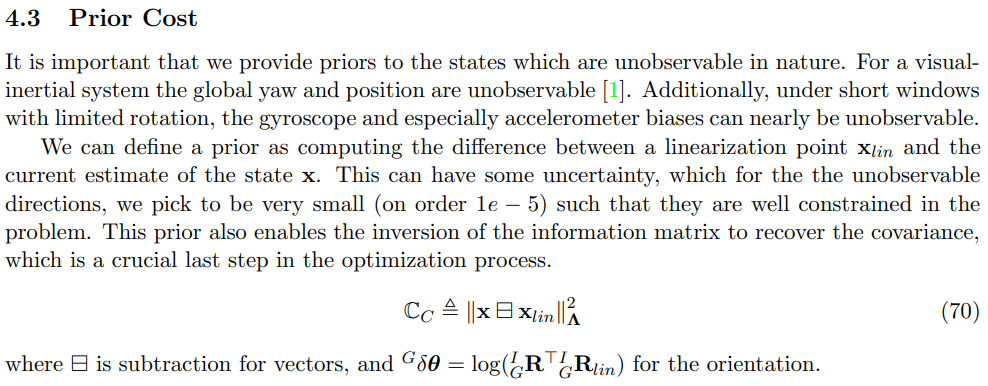

## 4.3 Prior Cost

It is important that we provide priors to the states which are unobservable in nature. For a visual-inertial system the global yaw and position are unobservable [1]. Additionally, under short windows with limited rotation, the gyroscope and especially accelerometer biases can nearly be unobservable.

We can define a prior as computing the difference between a linearization point $\mathbf{x}_{lin}$ and the current estimate of the state $\mathbf{x}$. This can have some uncertainty, which for the the unobservable directions, we pick to be very small (on order $1e-5$) such that they are well constrained in the problem. This prior also enables the inversion of the information matrix to recover the covariance, which is a crucial last step in the optimization process.

$$
C_C \triangleq \|\mathbf{x} \boxminus \mathbf{x}_{lin}\|^2_{\mathbf{\Lambda}} \tag{70}
$$

where $\boxminus$ is subtraction for vectors, and ${}^{G}\mathbf{\delta}\mathbf{\theta} = \text{log}({}^{I}_{G}\mathbf{R}\ {}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}})$ for the orientation.


$$
{}^{I}_{G}\mathbf{R}_{lin}\exp(\delta\mathbf{\theta}) = {}^{I}_{G}\mathbf{R}
$$

$$
\exp(-\delta\mathbf{\theta})\ {}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}} = {}^{I}_{G}\mathbf{R}^{\mathsf{T}}
$$

$$
\delta\mathbf{\theta} = -\text{log}\left( {}^{I}_{G}\mathbf{R}^{\mathsf{T}}\ {}^{I}_{G}\mathbf{R}_{lin} \right)
$$

$$
\mathbf{r} + \hat{\mathbf{r}} = -\text{log}\left[ \left(\exp(-\delta\mathbf{\theta})\ {}^{I}_{G}\hat{\mathbf{R}}\right)^{\mathsf{T}}\ {}^{I}_{G}\mathbf{R}_{lin} \right]
$$

$$
= -\text{log}\left[ {}^{I}_{G}\mathbf{R}^{\mathsf{T}}\ \exp(\delta\mathbf{\theta})\ {}^{I}_{G}\mathbf{R}_{lin} \right]
$$

$$
= -\text{log}\left[ \underbrace{{}^{I}_{G}\mathbf{R}^{\mathsf{T}}\ {}^{I}_{G}\mathbf{R}_{lin}}_{\delta\mathbf{R}}\ \exp\left( {}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}}\ \delta\mathbf{\theta} \right) \right]
$$

$$
= -\text{log}\left[\delta\mathbf{R}\right] - \underbrace{\mathcal{J}^{-1}_{r}\left(\text{log} \left[\delta\mathbf{R}\right]\right)\ {}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}}}_{\text{H}}\delta\text{O}
$$


$$
{}^{I}_{G}\mathbf{\breve{R}}\exp([0;0;\psi]) = {}^{I}_{G}\mathbf{R}
$$

$$
\exp(-\mathbf{\psi\mathbf{e}_{3}})\ {}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}} = {}^{I}_{G}\mathbf{R}^{\mathsf{T}}
$$

$$
\mathbf{\Psi} = -\mathbf{e}_{3}^{\mathsf{T}} \log \left( {}^{I}_{G}\mathbf{R}^{\mathsf{T}}\ {}^{I}_{G}\mathbf{R}_{lin} \right)
$$

$$
\mathbf{\Psi} + \hat{\mathbf{\Psi}} = -\mathbf{e}_{3}^{\mathsf{T}} \log \left( [\exp(-\delta\mathbf{\theta})\ {}^{I}_{G}\mathbf{\hat{R}}]^{\mathsf{T}}\ {}^{I}_{G}\mathbf{R}_{lin} \right)
$$

$$
= -\mathbf{e}_{3}^{\mathsf{T}} \log \left( \underbrace{{}^{I}_{G}\mathbf{\hat{R}}^{\mathsf{T}}\ {}^{I}_{G}\mathbf{R}_{lin}}_{\delta\text{R}} \exp\left({}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}}\ \delta\mathbf{\theta}\right) \right)
$$

$$
= -\mathbf{e}_{3}^{\mathsf{T}} \log \left(\delta\mathbf{R}\right) - \mathbf{e}_{3}^{\mathsf{T}}\ \mathcal{J}^{-1}_{r}\left(\log(\delta\mathbf{R})\right)\ {}^{I}_{G}\mathbf{R}_{lin}^{\mathsf{T}}\ \delta\mathbf{\theta}
$$


## Covariance
```
Eigen::LLT<Eigen::MatrixXd> lltOfI(prior_Info);
sqrtI = lltOfI.matrixL().transpose();
res = sqrtI * res;
```

## STEP 10: Nonlinear Refinement (Ceres Optimization)


In [14]:
# Lines 572-898: Setup and solve nonlinear optimization problem
# 
# This section uses Ceres Solver (C++ library) for maximum likelihood estimation.
# In Python, we use pyopenvins.Optimizer which runs Ceres in C++.

# ======================================================
# STEP 1: Setup Python paths and imports
# ======================================================
import sys

# Add pyopenvins to path BEFORE importing
pyopenvins_dir = '/home/abhishek/Desktop/Brinc/Software/brinc-openvins-manager/python/pyopenvins'
if pyopenvins_dir not in sys.path:
    sys.path.insert(0, pyopenvins_dir)

# Now we can import
from optimize_mle import optimize_mle_python

print("""
Nonlinear Refinement Overview:
-------------------------------
The C++ implementation uses Ceres Solver to refine the linear initialization.

Optimization Variables:
  - IMU states (16-DOF): orientation(4), position(3), velocity(3), bias_g(3), bias_a(3)
  - Feature positions (3-DOF each)
  - Camera extrinsics (7-DOF each, optional)
  - Camera intrinsics (8-DOF each, optional)

Cost Function:
  - Prior on first pose (fixes unobservable DOF)
  - Prior on biases
  - IMU preintegration residuals (9-DOF)
  - Reprojection residuals (2-DOF per observation)

Solver Configuration:
  - Linear solver: SPARSE_SCHUR (default in pyopenvins)
  - Cauchy loss for reprojection (robust to outliers)
  
Using pyopenvins.Optimizer for Python-accessible Ceres optimization.
""")

# ======================================================
# STEP 2: Prepare data for optimization
# ======================================================
import os, time
print(f'Python PID: {os.getpid()}')
# time.sleep(100)
# Use gravity in global frame (downward)
gravity = np.array([0.0, 0.0, params['gravity_mag']])

# Get biases from parameters
gyroscope_bias = params.get('init_dyn_bias_g', np.zeros(3))
accelerometer_bias = params.get('init_dyn_bias_a', np.zeros(3))

# Prepare camera parameters dict
camera_params = {
    'camera_ids': list(params.get('camera_extrinsics', {}).keys()),
    'extrinsics': {},
    'intrinsics': {},
    'is_fisheye': {},
}

for cam_id in camera_params['camera_ids']:
    extr = params['camera_extrinsics'][cam_id]
    camera_params['extrinsics'][cam_id] = {
        'q_ItoC': extr[:4],
        'p_IinC': extr[4:7],
    }
    
    # Get intrinsics [fx, fy, cx, cy, k1, k2, k3, k4]
    intr = params['camera_intrinsics'][cam_id]
    if hasattr(intr, 'get_value'):
        camera_params['intrinsics'][cam_id] = intr.get_value().flatten()
    else:
        camera_params['intrinsics'][cam_id] = intr
    
    # Determine if fisheye
    camera_params['is_fisheye'][cam_id] = True

# Prepare features dict with proper structure
features_opt = {}
for feat_id, feat in features.items():
    if map_features_num_meas.get(feat_id, 0) >= min_num_meas_to_optimize:
        features_opt[feat_id] = {
            'num_meas': map_features_num_meas[feat_id],
            'timestamps': feat["timestamps"],
            'uvs': feat["uvs"],
        }

# Optimization parameters
opt_params = {
    'max_iter': params.get('init_dyn_mle_max_iter', 50),
    'verbose': True,
    'optimize_calib': params.get('init_dyn_mle_opt_calib', False),
    'min_num_meas': min_num_meas_to_optimize,
    'sigma_pix': params.get('sigma_pix', 1.0),
    'save_residuals': False,  # Add this
    'residuals_file': 'residuals_python_initial.txt',  # Optional
    # ... other params
}

print("✓ Prepared optimization parameters")
print(f"  - {len(map_camera_times)} IMU states")
print(f"  - {len(features_opt)} features to optimize")
print(f"  - {len(camera_params['camera_ids'])} cameras")

# ======================================================
# STEP 3: Run nonlinear optimization
# ======================================================

success, optimized_states, summary, counts = optimize_mle_python(
    map_camera_times,          # Dict[float, int]: timestamp -> index
    map_camera_cpi_IitoIi1,   # Dict[float, CPI]: timestamp -> preintegration (camera to camera)
    ori_GtoIi,                 # Dict[float, np.array(4,)]: timestamp -> orientation
    pos_IiinG,                 # Dict[float, np.array(3,)]: timestamp -> position
    vel_IiinG,                 # Dict[float, np.array(3,)]: timestamp -> velocity
    gyroscope_bias,            # np.array(3,): current gyro bias
    accelerometer_bias,        # np.array(3,): current accel bias
    gravity,                   # np.array(3,): gravity vector (FIXED - was gravity_global)
    features_opt,              # Dict[int, Feature]: feature observations (FIXED - was features)
    features_inG,              # Dict[int, np.array(3,)]: feature 3D positions
    camera_params,             # Dict: camera calibration
    opt_params,                 # Dict: optimization parameters
    log_file='optimization_log.json'  # Enable detailed logging
)

if success:
    print("\n" + "="*70)
    print("✓ Optimization completed successfully!")
    print("="*70)
else:
    print("\n" + "="*70)
    print("⚠ Optimization did not converge")
    print("="*70)


Nonlinear Refinement Overview:
-------------------------------
The C++ implementation uses Ceres Solver to refine the linear initialization.

Optimization Variables:
  - IMU states (16-DOF): orientation(4), position(3), velocity(3), bias_g(3), bias_a(3)
  - Feature positions (3-DOF each)
  - Camera extrinsics (7-DOF each, optional)
  - Camera intrinsics (8-DOF each, optional)

Cost Function:
  - Prior on first pose (fixes unobservable DOF)
  - Prior on biases
  - IMU preintegration residuals (9-DOF)
  - Reprojection residuals (2-DOF per observation)

Solver Configuration:
  - Linear solver: SPARSE_SCHUR (default in pyopenvins)
  - Cauchy loss for reprojection (robust to outliers)
  
Using pyopenvins.Optimizer for Python-accessible Ceres optimization.

Python PID: 249398
✓ Prepared optimization parameters
  - 8 IMU states
  - 162 features to optimize
  - 2 cameras
Python Nonlinear MLE Optimization (using pyopenvins)

🐛 Debug logging DISABLED

Adding 8 IMU states...
  ✓ Added prior on f

## Extract Optimized States

This section implements the state extraction logic from `DynamicInitializer.cpp` lines 2747-2809.
After Ceres optimization, we extract:
- IMU state (16-DOF): orientation, position, velocity, gyro bias, accel bias
- IMU clones (pose history for sliding window filter)
- SLAM features (3D landmarks)

In [15]:
# ======================================================
# EXTRACT OPTIMIZED STATES
# (DynamicInitializer.cpp lines 2747-2809)
# ======================================================

if success and data_loaded:
    print("="*70)
    print("Extracting Optimized States")
    print("="*70)
    
    # Helper function to extract the optimized IMU state from optimization variables
    # Returns 16-DOF state: [q_GtoI(4), p_IinG(3), v_IinG(3), bg(3), ba(3)]
    def get_pose(timestamp):
        """
        Extract 16-DOF IMU state at given timestamp.
        
        Args:
            timestamp: float - Time at which to extract state
            
        Returns:
            state_imu: np.array(16,) - [q_GtoI(4), p_IinG(3), v_IinG(3), bg(3), ba(3)]
        """
        state_imu = np.zeros(16)
        
        # Get optimized values from Ceres optimizer
        state = optimized_states['states'][timestamp]
        
        # Orientation (JPL quaternion: x, y, z, w)
        state_imu[0:4] = state['q']
        
        # Position
        state_imu[4:7] = state['p']
        
        # Velocity
        state_imu[7:10] = state['v']
        
        # Gyroscope bias
        state_imu[10:13] = state['bg']
        
        # Accelerometer bias
        state_imu[13:16] = state['ba']
        
        return state_imu
    
    # ======================================================
    # Extract the most recent IMU state (this will be used to initialize the filter)
    # ======================================================
    
    # Get the newest camera time from map_camera_times
    newest_cam_time = max(map_camera_times.keys())
    
    print(f"\n📌 Extracting IMU state at newest time: {newest_cam_time:.6f}s")
    
    # Extract state
    _imu_state = get_pose(newest_cam_time)
    
    print(f"\n✓ Current IMU State (16-DOF):")
    print(f"  Orientation (q_GtoI):   [{_imu_state[0]:.6f}, {_imu_state[1]:.6f}, {_imu_state[2]:.6f}, {_imu_state[3]:.6f}]")
    print(f"  Position (p_IinG):      [{_imu_state[4]:.6f}, {_imu_state[5]:.6f}, {_imu_state[6]:.6f}]")
    print(f"  Velocity (v_IinG):      [{_imu_state[7]:.6f}, {_imu_state[8]:.6f}, {_imu_state[9]:.6f}]")
    print(f"  Gyro bias (bg):         [{_imu_state[10]:.6f}, {_imu_state[11]:.6f}, {_imu_state[12]:.6f}]")
    print(f"  Accel bias (ba):        [{_imu_state[13]:.6f}, {_imu_state[14]:.6f}, {_imu_state[15]:.6f}]")
    
    # ======================================================
    # Extract all IMU clones (pose history for sliding window filter)
    # These are poses at each camera observation time
    # ======================================================
    
    print(f"\n📌 Extracting {len(map_camera_times)} IMU clones (pose history)...")
    
    _clones_IMU = {}
    
    for timestamp in map_camera_times.keys():
        # Get full 16-DOF state
        pose = get_pose(timestamp)
        
        # IMU clone only stores orientation (4) + position (3) = 7-DOF
        clone_pose = pose[0:7]
        
        _clones_IMU[timestamp] = {
            'value': clone_pose.copy(),  # Current value
            'fej': clone_pose.copy()     # First-estimate Jacobian linearization point
        }
    
    print(f"✓ Extracted {len(_clones_IMU)} clones")
    
    # Display first and last clone
    first_time = min(_clones_IMU.keys())
    last_time = max(_clones_IMU.keys())
    
    print(f"\n  First clone at t={first_time:.6f}s:")
    print(f"    q_GtoI: [{_clones_IMU[first_time]['value'][0]:.6f}, {_clones_IMU[first_time]['value'][1]:.6f}, {_clones_IMU[first_time]['value'][2]:.6f}, {_clones_IMU[first_time]['value'][3]:.6f}]")
    print(f"    p_IinG: [{_clones_IMU[first_time]['value'][4]:.6f}, {_clones_IMU[first_time]['value'][5]:.6f}, {_clones_IMU[first_time]['value'][6]:.6f}]")
    
    print(f"\n  Last clone at t={last_time:.6f}s:")
    print(f"    q_GtoI: [{_clones_IMU[last_time]['value'][0]:.6f}, {_clones_IMU[last_time]['value'][1]:.6f}, {_clones_IMU[last_time]['value'][2]:.6f}, {_clones_IMU[last_time]['value'][3]:.6f}]")
    print(f"    p_IinG: [{_clones_IMU[last_time]['value'][4]:.6f}, {_clones_IMU[last_time]['value'][5]:.6f}, {_clones_IMU[last_time]['value'][6]:.6f}]")
    
    # ======================================================
    # Extract optimized 3D feature positions as SLAM features
    # These will be used as initial landmarks in the filter
    # ======================================================
    
    print(f"\n📌 Extracting {len(optimized_states['features'])} SLAM features (3D landmarks)...")
    
    _features_SLAM = {}
    
    for feat_id, p_FinG in optimized_states['features'].items():
        _features_SLAM[feat_id] = {
            'featid': feat_id,
            'representation': 'GLOBAL_3D',
            'value': p_FinG.copy(),  # Current 3D position
            'fej': p_FinG.copy()     # First-estimate Jacobian linearization point
        }
    
    print(f"✓ Extracted {len(_features_SLAM)} SLAM features")
    
    # Display statistics
    feature_positions = np.array([f['value'] for f in _features_SLAM.values()])
    
    print(f"\n  Feature position statistics:")
    print(f"    X range: [{feature_positions[:, 0].min():.3f}, {feature_positions[:, 0].max():.3f}]")
    print(f"    Y range: [{feature_positions[:, 1].min():.3f}, {feature_positions[:, 1].max():.3f}]")
    print(f"    Z range: [{feature_positions[:, 2].min():.3f}, {feature_positions[:, 2].max():.3f}]")
    print(f"    Mean distance from origin: {np.linalg.norm(feature_positions, axis=1).mean():.3f} m")
    
    # Display first few features
    print(f"\n  Sample features:")
    for i, (feat_id, feat) in enumerate(list(_features_SLAM.items())[:3]):
        print(f"    Feature {feat_id}: [{feat['value'][0]:.3f}, {feat['value'][1]:.3f}, {feat['value'][2]:.3f}]")
    
    print("\n" + "="*70)
    print("✓ State extraction complete!")
    print("="*70)
    
    print(f"""
Summary of Extracted States:
-----------------------------
• IMU State (current):     16-DOF state ready for filter initialization
• IMU Clones:              {len(_clones_IMU)} poses for sliding window
• SLAM Features:           {len(_features_SLAM)} 3D landmarks for tracking

These states can now be used to initialize the visual-inertial odometry filter.
The IMU state provides initial orientation, position, velocity and biases.
The clones maintain pose history for marginalization.
The SLAM features provide initial landmarks for visual tracking.
""")
    
else:
    if not success:
        print("⚠ Skipping state extraction (optimization failed)")
    else:
        print("⚠ Skipping state extraction (no data loaded)")

Extracting Optimized States

📌 Extracting IMU state at newest time: 2.732933s

✓ Current IMU State (16-DOF):
  Orientation (q_GtoI):   [0.000804, 0.008566, -0.965636, 0.259755]
  Position (p_IinG):      [-1.454805, -1.715136, 1.830992]
  Velocity (v_IinG):      [-0.670408, -0.837800, 0.336600]
  Gyro bias (bg):         [0.019657, 0.009519, -0.005487]
  Accel bias (ba):        [-0.000111, 0.006501, 0.052094]

📌 Extracting 8 IMU clones (pose history)...
✓ Extracted 8 clones

  First clone at t=0.233547s:
    q_GtoI: [0.000218, 0.000363, 1.000000, 0.000075]
    p_IinG: [-0.000000, -0.000000, 0.000000]

  Last clone at t=2.732933s:
    q_GtoI: [0.000804, 0.008566, -0.965636, 0.259755]
    p_IinG: [-1.454805, -1.715136, 1.830992]

📌 Extracting 162 SLAM features (3D landmarks)...
✓ Extracted 162 SLAM features

  Feature position statistics:
    X range: [-16.543, 3.768]
    Y range: [-14.538, 3.755]
    Z range: [-2.548, 3.604]
    Mean distance from origin: 6.849 m

  Sample features:
    F

In [16]:
from tools.visualize_optimization import (
    visualize_factor_graph,
    visualize_factor_graph_3d,
    visualize_factor_graph_3d_animation,
    visualize_optimization, 
    visualize_3d_trajectory
)

# Abstract factor graph (topology)
visualize_factor_graph('optimization_log.json')

# 3D Euclidean factor graph (real-world positions)
visualize_factor_graph_3d('optimization_log.json', iteration=-1)

# Animated convergence
visualize_factor_graph_3d_animation('optimization_log.json')

# Optimization metrics
visualize_optimization('optimization_log.json')

# 3D trajectories
visualize_3d_trajectory('optimization_log.json')

Loading optimization log from: optimization_log.json
Factor graph: 173 nodes, 510 edges


Loading optimization log from: optimization_log.json
Visualizing iteration 24 (of 25 total)
Found 8 poses, 162 features


Loading optimization log from: optimization_log.json
Creating animation with 25 frames


Loading optimization log from: optimization_log.json
Loaded 25 iterations


Loading optimization log from: optimization_log.json
